In [125]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle                  # serialization stdlib
import sklearn.preprocessing
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
%matplotlib inline

In [4]:
# Check kernel.json references generic "python3", not sys.path.python3
# !pip freeze  pandas=1.1.5
pd.__version__

'1.1.5'

In [5]:
brazil_df = pd.read_excel("dataset.xlsx")
brazil_df.head()


Patient ID  Patient age quantile SARS-Cov-2 exam result  \
0  44477f75e8169d2                    13               negative   
1  126e9dd13932f68                    17               negative   
2  a46b4402a0e5696                     8               negative   
3  f7d619a94f97c45                     5               negative   
4  d9e41465789c2b5                    15               negative   

   Patient addmited to regular ward (1=yes, 0=no)  \
0                                               0   
1                                               0   
2                                               0   
3                                               0   
4                                               0   

   Patient addmited to semi-intensive unit (1=yes, 0=no)  \
0                                                  0       
1                                                  0       
2                                                  0       
3                                                  0       
4                                                  0       

   Patient addmited to intensive care unit (1=yes, 0=no)  Hematocrit  \
0                                                  0             NaN   
1                                                  0        0.236515   
2                                                  0             NaN   
3                                                  0             NaN   
4                                                  0             NaN   

   Hemoglobin  Platelets  Mean platelet volume   ...  \
0         NaN        NaN                    NaN  ...   
1    -0.02234  -0.517413               0.010677  ...   
2         NaN        NaN                    NaN  ...   
3         NaN        NaN                    NaN  ...   
4         NaN        NaN                    NaN  ...   

   Hb saturation (arterial blood gases)  pCO2 (arterial blood gas analysis)  \
0                                   NaN                                 NaN   
1                                   NaN                                 NaN   
2                                   NaN                                 NaN   
3                                   NaN                                 NaN   
4                                   NaN                                 NaN   

   Base excess (arterial blood gas analysis)  \
0                                        NaN   
1                                        NaN   
2                                        NaN   
3                                        NaN   
4                                        NaN   

   pH (arterial blood gas analysis)  Total CO2 (arterial blood gas analysis)  \
0                               NaN                                      NaN   
1                               NaN                                      NaN   
2                               NaN                                      NaN   
3                               NaN                                      NaN   
4                               NaN                                      NaN   

   HCO3 (arterial blood gas analysis)  pO2 (arterial blood gas analysis)  \
0                                 NaN                                NaN   
1                                 NaN                                NaN   
2                                 NaN                                NaN   
3                                 NaN                                NaN   
4                                 NaN                                NaN   

   Arteiral Fio2  Phosphor  ctO2 (arterial blood gas analysis)  
0            NaN       NaN                                 NaN  
1            NaN       NaN                                 NaN  
2            NaN       NaN                                 NaN  
3            NaN       NaN                                 NaN  
4            NaN       NaN                                 NaN  

[5 rows x 111 columns]

In [6]:
# Checking null counts
# pd.set_option('display.max_rows', None)
null_count = brazil_df.isnull().sum().sort_values()
null_count

Patient ID                                                  0
Patient age quantile                                        0
SARS-Cov-2 exam result                                      0
Patient addmited to regular ward (1=yes, 0=no)              0
Patient addmited to semi-intensive unit (1=yes, 0=no)       0
                                                         ... 
Partial thromboplastin time (PTT)                        5644
Urine - Sugar                                            5644
Mycoplasma pneumoniae                                    5644
D-Dimer                                                  5644
Prothrombin time (PT), Activity                          5644
Length: 111, dtype: int64

In [7]:
# Cell is trying to look at a cutoff for missing values.  i.e. Candidates for row deletion
## OUTCOME:  There are too many sparse values in the dataset...Not sure how to deal with it

threshold = 0.80
null_cutoff = threshold * brazil_df.shape[0]

print(f"Null threshold: {threshold}%, Null count: {null_cutoff}")
print(null_count[null_count > null_cutoff].count())


Null threshold: 0.8%, Null count: 4515.2
88


In [8]:
bloods = ['Proteina C reativa mg/dL', 
                'Neutrophils', 
                'Mean platelet volume ', 
                'Monocytes', 
                'Red blood cell distribution width (RDW)', 
                'Red blood Cells',
                'Platelets',
                'Eosinophils',
                'Basophils',
                'Leukocytes',
                'Mean corpuscular hemoglobin (MCH)',
                'Mean corpuscular volume (MCV)',
                'Mean corpuscular hemoglobin concentration\xa0(MCHC)',
                'Lymphocytes',
                'Hemoglobin',
                'Hematocrit']
influenza = ['Influenza A','Influenza B']

brazil_vars = ["SARS-Cov-2 exam result","Patient age quantile"] + bloods + influenza
brazil_vars

['SARS-Cov-2 exam result',
 'Patient age quantile',
 'Proteina C reativa mg/dL',
 'Neutrophils',
 'Mean platelet volume ',
 'Monocytes',
 'Red blood cell distribution width (RDW)',
 'Red blood Cells',
 'Platelets',
 'Eosinophils',
 'Basophils',
 'Leukocytes',
 'Mean corpuscular hemoglobin (MCH)',
 'Mean corpuscular volume (MCV)',
 'Mean corpuscular hemoglobin concentration\xa0(MCHC)',
 'Lymphocytes',
 'Hemoglobin',
 'Hematocrit',
 'Influenza A',
 'Influenza B']

## Data disparity
* Some people have had Flu test, but no bloods
* Much more others have had just their bloods taken...
    * Can we remove those with NaNs for bloods at the risk of removing the Flu detection?

In [9]:
brazil_edit = brazil_df[brazil_vars]
brazil_edit.head()

SARS-Cov-2 exam result  Patient age quantile  Proteina C reativa mg/dL  \
0               negative                    13                       NaN   
1               negative                    17                 -0.147895   
2               negative                     8                       NaN   
3               negative                     5                       NaN   
4               negative                    15                       NaN   

   Neutrophils  Mean platelet volume   Monocytes  \
0          NaN                    NaN        NaN   
1    -0.619086               0.010677   0.357547   
2          NaN                    NaN        NaN   
3          NaN                    NaN        NaN   
4          NaN                    NaN        NaN   

   Red blood cell distribution width (RDW)  Red blood Cells  Platelets  \
0                                      NaN              NaN        NaN   
1                                -0.625073         0.102004  -0.517413   
2                                      NaN              NaN        NaN   
3                                      NaN              NaN        NaN   
4                                      NaN              NaN        NaN   

   Eosinophils  Basophils  Leukocytes  Mean corpuscular hemoglobin (MCH)  \
0          NaN        NaN         NaN                                NaN   
1     1.482158  -0.223767    -0.09461                          -0.292269   
2          NaN        NaN         NaN                                NaN   
3          NaN        NaN         NaN                                NaN   
4          NaN        NaN         NaN                                NaN   

   Mean corpuscular volume (MCV)  \
0                            NaN   
1                       0.166192   
2                            NaN   
3                            NaN   
4                            NaN   

   Mean corpuscular hemoglobin concentration (MCHC)  Lymphocytes  Hemoglobin  \
0                                               NaN          NaN         NaN   
1                                          -0.95079     0.318366    -0.02234   
2                                               NaN          NaN         NaN   
3                                               NaN          NaN         NaN   
4                                               NaN          NaN         NaN   

   Hematocrit   Influenza A   Influenza B  
0         NaN           NaN           NaN  
1    0.236515  not_detected  not_detected  
2         NaN           NaN           NaN  
3         NaN           NaN           NaN  
4         NaN  not_detected  not_detected

In [10]:
# What is our Class Imbalance situation?

brazil_edit["SARS-Cov-2 exam result"].value_counts()

negative    5086
positive     558
Name: SARS-Cov-2 exam result, dtype: int64

In [11]:
# Filtered data set information
brazil_edit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5644 entries, 0 to 5643
Data columns (total 20 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   SARS-Cov-2 exam result                            5644 non-null   object 
 1   Patient age quantile                              5644 non-null   int64  
 2   Proteina C reativa mg/dL                          506 non-null    float64
 3   Neutrophils                                       513 non-null    float64
 4   Mean platelet volume                              599 non-null    float64
 5   Monocytes                                         601 non-null    float64
 6   Red blood cell distribution width (RDW)           602 non-null    float64
 7   Red blood Cells                                   602 non-null    float64
 8   Platelets                                         602 non-null    float64
 9   Eosinophils        

## Significant number of Influenza Type A and B records exist as untested
* We make the decision to include the "N/A" variables as a DUMMY in our model to preserve information

In [12]:
# Checking out other categorical variables.  
#! Note: Value_Counts() excludes NaN. Is this a problem?  
#! Count of missing values are larger than actual data => unwise to add as category


print("Detection of Influenza A: \n", brazil_edit["Influenza A"].value_counts())

print("\nDetection of Influenza B: \n", brazil_edit["Influenza B"].value_counts())


Detection of Influenza A: 
 not_detected    1336
detected          18
Name: Influenza A, dtype: int64

Detection of Influenza B: 
 not_detected    1277
detected          77
Name: Influenza B, dtype: int64


In [13]:
# Not sure if this helps...How to remove the scientific notation??
brazil_edit.describe().round(2)

Patient age quantile  Proteina C reativa mg/dL  Neutrophils  \
count               5644.00                    506.00       513.00   
mean                   9.32                      0.00         0.00   
std                    5.78                      1.00         1.00   
min                    0.00                     -0.54        -3.34   
25%                    4.00                     -0.51        -0.65   
50%                    9.00                     -0.39        -0.05   
75%                   14.00                      0.03         0.68   
max                   19.00                      8.03         2.54   

       Mean platelet volume   Monocytes  \
count                 599.00     601.00   
mean                    0.00      -0.00   
std                     1.00       1.00   
min                    -2.46      -2.16   
25%                    -0.66      -0.61   
50%                    -0.10      -0.12   
75%                     0.68       0.49   
max                     3.71       4.53   

       Red blood cell distribution width (RDW)  Red blood Cells  Platelets  \
count                                   602.00           602.00     602.00   
mean                                      0.00             0.00      -0.00   
std                                       1.00             1.00       1.00   
min                                      -1.60            -3.97      -2.55   
25%                                      -0.63            -0.57      -0.61   
50%                                      -0.18             0.01      -0.12   
75%                                       0.35             0.67       0.53   
max                                       6.98             3.65       9.53   

       Eosinophils  Basophils  Leukocytes  Mean corpuscular hemoglobin (MCH)  \
count       602.00     602.00      602.00                             602.00   
mean          0.00      -0.00        0.00                              -0.00   
std           1.00       1.00        1.00                               1.00   
min          -0.84      -1.14       -2.02                              -5.94   
25%          -0.67      -0.53       -0.64                              -0.50   
50%          -0.33      -0.22       -0.21                               0.13   
75%           0.34       0.39        0.45                               0.60   
max           8.35      11.08        4.52                               4.10   

       Mean corpuscular volume (MCV)  \
count                         602.00   
mean                           -0.00   
std                             1.00   
min                            -5.10   
25%                            -0.51   
50%                             0.07   
75%                             0.63   
max                             3.41   

       Mean corpuscular hemoglobin concentration (MCHC)  Lymphocytes  \
count                                            602.00       602.00   
mean                                               0.00        -0.00   
std                                                1.00         1.00   
min                                               -5.43        -1.87   
25%                                               -0.55        -0.73   
50%                                               -0.05        -0.01   
75%                                                0.64         0.60   
max                                                3.33         3.76   

       Hemoglobin  Hematocrit  
count      603.00      603.00  
mean        -0.00       -0.00  
std          1.00        1.00  
min         -4.35       -4.50  
25%         -0.59       -0.52  
50%          0.04        0.05  
75%          0.73        0.72  
max          2.67        2.66

## Pairplots:  what are we looking for exactly
* Shape of the frequency distributions across the diagnoals
* Clear linear trends?
    * -Corr(Lymphocytes, Neutrophils)
    * +Corr(Haemoglobin, Red blood cells)
    * +Corr(Hematocrit, Red blood cells)
    * +Corr(MCH, MCV)
    * +Corr(Haemoglobin, Haemocrit)

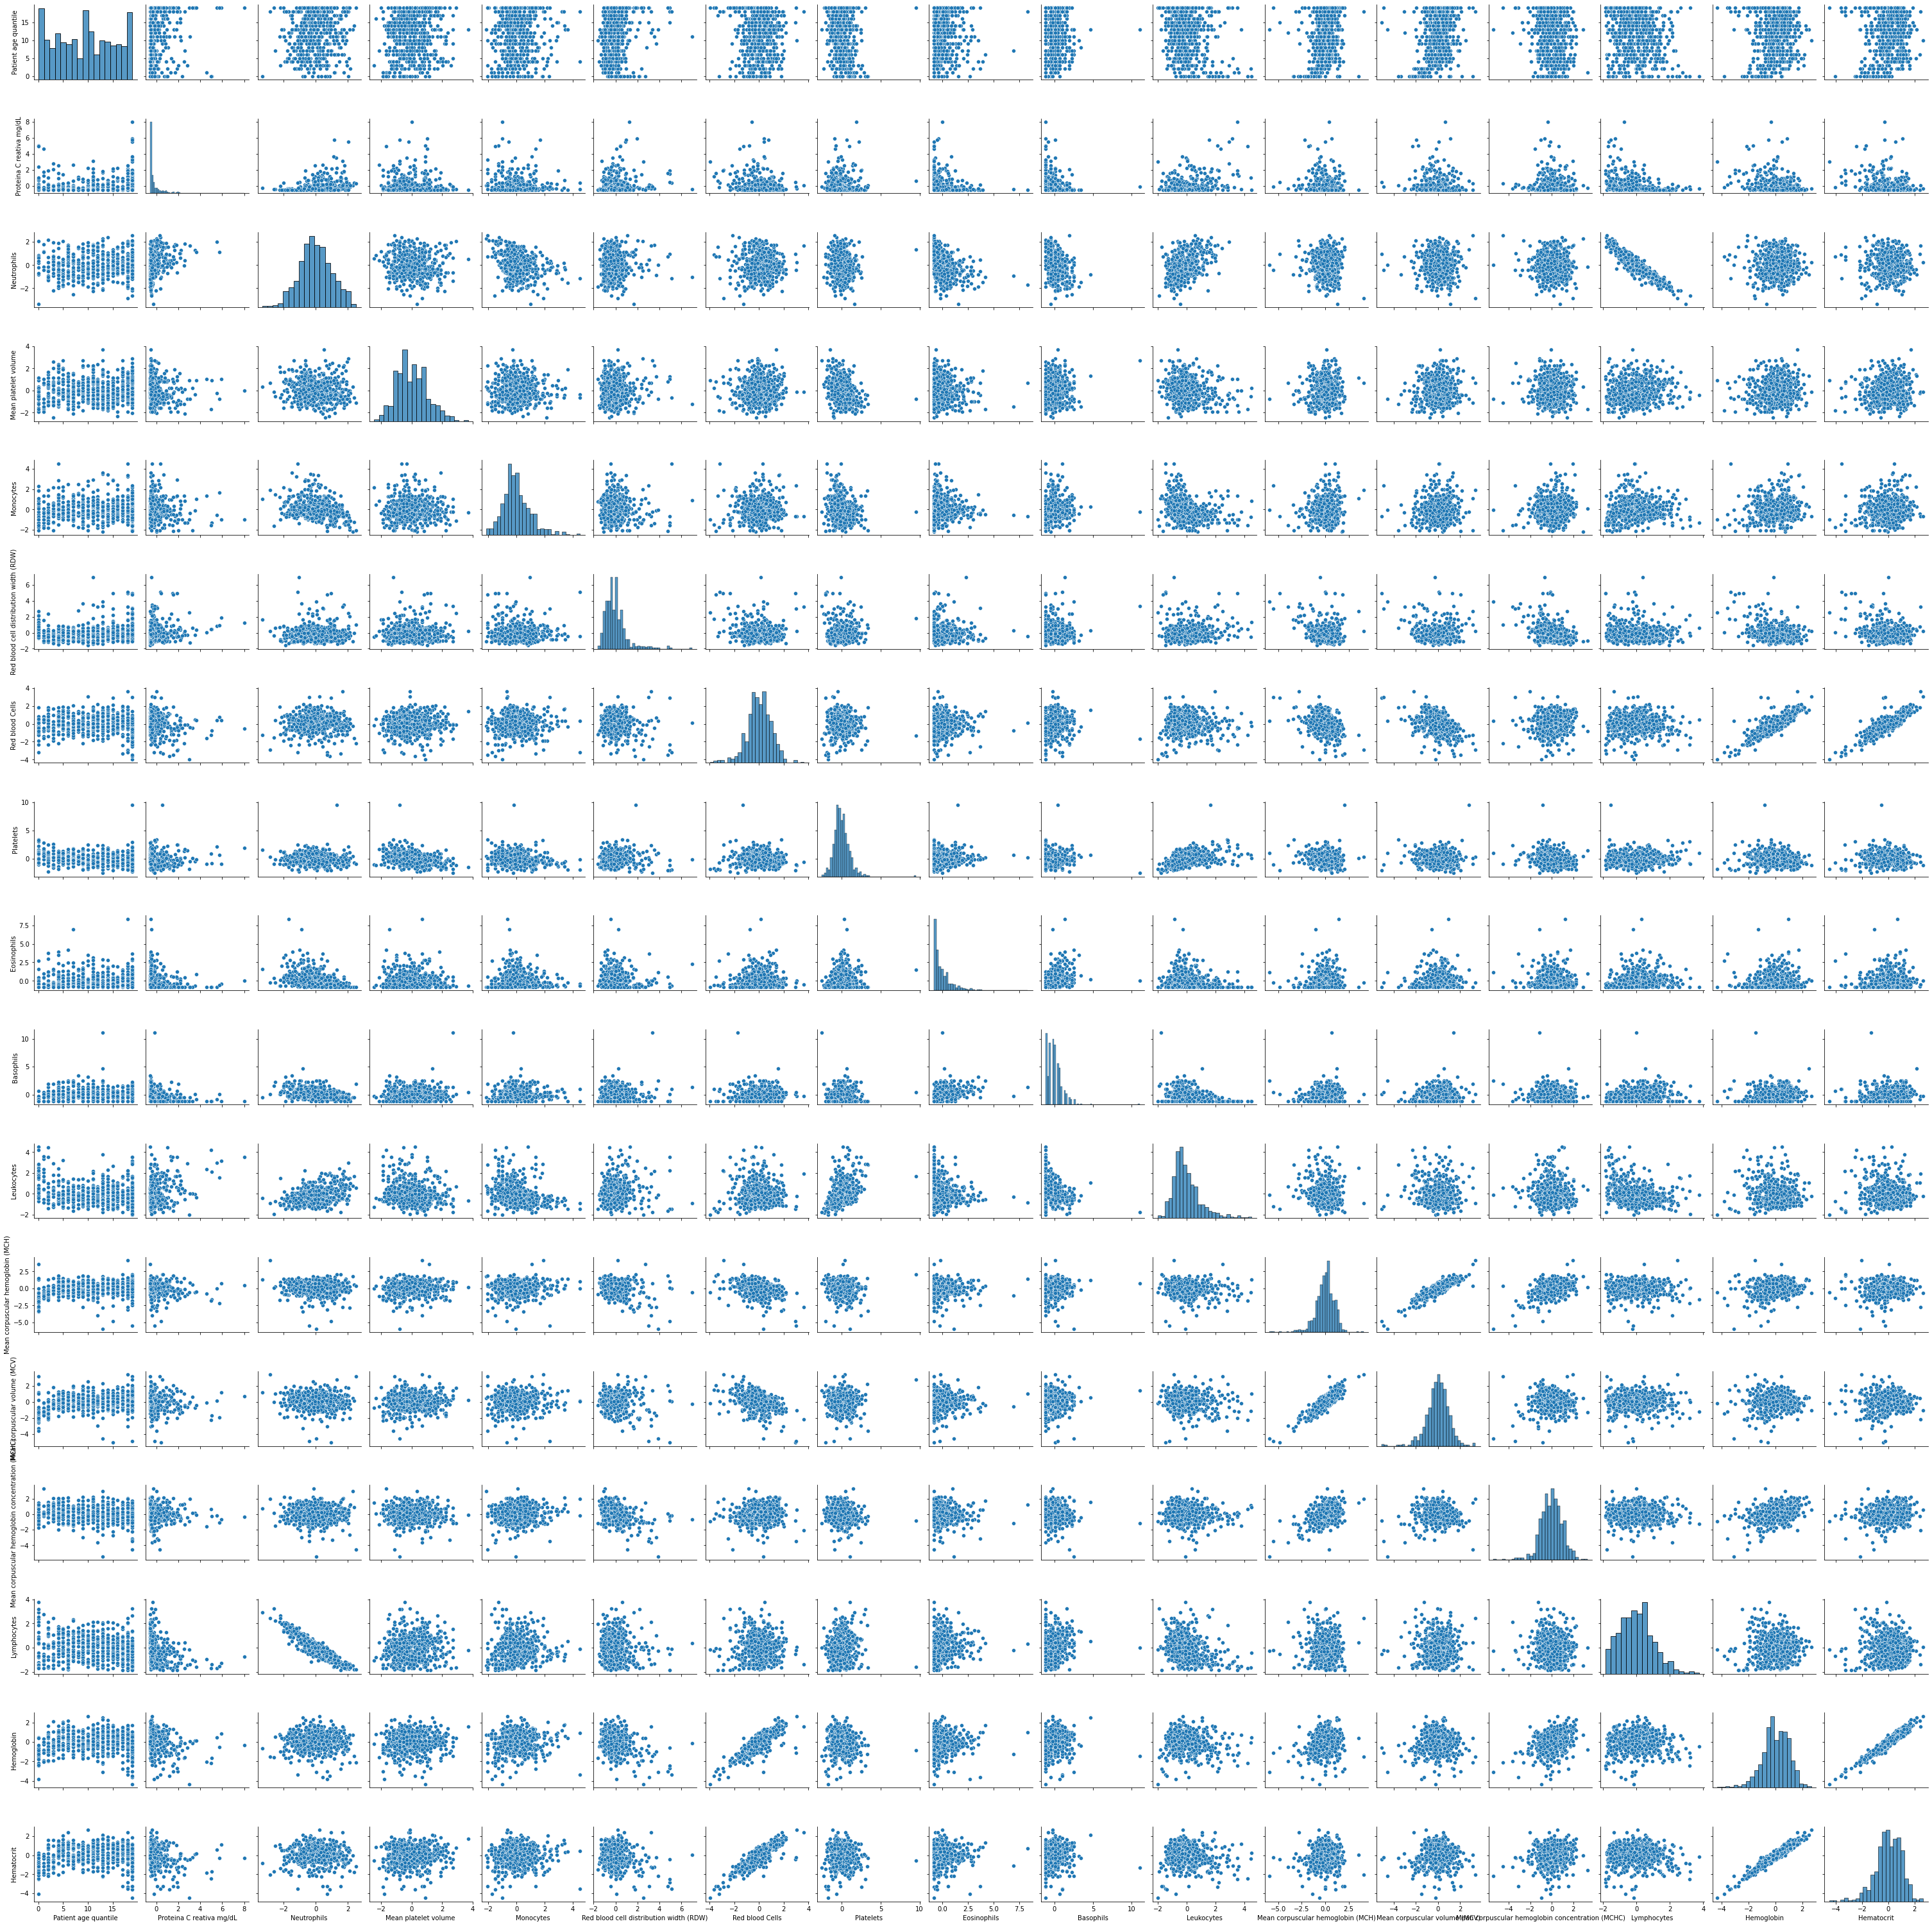

In [16]:
sns.pairplot(brazil_edit)

## Working on Preprocessing
* What kind of data do we have?
* Why are we performing predictive mining on this data?
* What information are we trying to predict?
* How could the stakeholders (including yourself) use the insights we gain from the data mining?

## Data preparation steps
1. Data cleaning: Dealing with missing values, correcting error values, normalization, and formatting data into a format suitable for the underlying algorithm and framework to be used. This includes setting correct data types for variables.
2. Data selection: Setting correct roles (input/target) for variables and perform feature selection for the analysis.
3. Data partition/distribution: Partition the data into test and train set using batch split to avoid overfitting.

## Encoding
#### Separate dummy_vars vs. mapping techniques for the Categorical Flu vars (with NaNs) vs. Target variable

In [14]:
## Encode the COVID test results:  into the same column
covid_map = {'negative':0, 'positive':1}
brazil_edit["SARS-Cov-2 exam result"] = brazil_edit["SARS-Cov-2 exam result"].map(covid_map)

## One-Hot Encoding technique, treating NaNs as a separate column
brazil_enc = pd.get_dummies(brazil_edit, columns=["Influenza A", "Influenza B"], dummy_na=True)
brazil_enc

/Users/DougNewton/Coding/DXM/Final/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


SARS-Cov-2 exam result  Patient age quantile  Proteina C reativa mg/dL  \
0                          0                    13                       NaN   
1                          0                    17                 -0.147895   
2                          0                     8                       NaN   
3                          0                     5                       NaN   
4                          0                    15                       NaN   
...                      ...                   ...                       ...   
5639                       1                     3                       NaN   
5640                       0                    17                       NaN   
5641                       0                     4                       NaN   
5642                       0                    10                       NaN   
5643                       1                    19                 -0.503570   

      Neutrophils  Mean platelet volume   Monocytes  \
0             NaN                    NaN        NaN   
1       -0.619086               0.010677   0.357547   
2             NaN                    NaN        NaN   
3             NaN                    NaN        NaN   
4             NaN                    NaN        NaN   
...           ...                    ...        ...   
5639          NaN                    NaN        NaN   
5640          NaN                    NaN        NaN   
5641          NaN                    NaN        NaN   
5642          NaN                    NaN        NaN   
5643     0.380685              -0.325903   0.567652   

      Red blood cell distribution width (RDW)  Red blood Cells  Platelets  \
0                                         NaN              NaN        NaN   
1                                   -0.625073         0.102004  -0.517413   
2                                         NaN              NaN        NaN   
3                                         NaN              NaN        NaN   
4                                         NaN              NaN        NaN   
...                                       ...              ...        ...   
5639                                      NaN              NaN        NaN   
5640                                      NaN              NaN        NaN   
5641                                      NaN              NaN        NaN   
5642                                      NaN              NaN        NaN   
5643                                -0.182790         0.578024  -0.906829   

      Eosinophils  ...  Mean corpuscular hemoglobin concentration (MCHC)  \
0             NaN  ...                                               NaN   
1        1.482158  ...                                         -0.950790   
2             NaN  ...                                               NaN   
3             NaN  ...                                               NaN   
4             NaN  ...                                               NaN   
...           ...  ...                                               ...   
5639          NaN  ...                                               NaN   
5640          NaN  ...                                               NaN   
5641          NaN  ...                                               NaN   
5642          NaN  ...                                               NaN   
5643    -0.835508  ...                                         -0.353319   

      Lymphocytes  Hemoglobin  Hematocrit  Influenza A_detected  \
0             NaN         NaN         NaN                     0   
1        0.318366   -0.022340    0.236515                     0   
2             NaN         NaN         NaN                     0   
3             NaN         NaN         NaN                     0   
4             NaN         NaN         NaN                     0   
...           ...         ...         ...                   ...   
5639          NaN         NaN         NaN                     0   
5640      

In [15]:
brazil_enc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5644 entries, 0 to 5643
Data columns (total 24 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   SARS-Cov-2 exam result                            5644 non-null   int64  
 1   Patient age quantile                              5644 non-null   int64  
 2   Proteina C reativa mg/dL                          506 non-null    float64
 3   Neutrophils                                       513 non-null    float64
 4   Mean platelet volume                              599 non-null    float64
 5   Monocytes                                         601 non-null    float64
 6   Red blood cell distribution width (RDW)           602 non-null    float64
 7   Red blood Cells                                   602 non-null    float64
 8   Platelets                                         602 non-null    float64
 9   Eosinophils        

In [16]:
# Percentages of missing values in each column:  Requirement to drop rows
brazil_enc.isna().mean().round(4)*100

SARS-Cov-2 exam result                               0.00
Patient age quantile                                 0.00
Proteina C reativa mg/dL                            91.03
Neutrophils                                         90.91
Mean platelet volume                                89.39
Monocytes                                           89.35
Red blood cell distribution width (RDW)             89.33
Red blood Cells                                     89.33
Platelets                                           89.33
Eosinophils                                         89.33
Basophils                                           89.33
Leukocytes                                          89.33
Mean corpuscular hemoglobin (MCH)                   89.33
Mean corpuscular volume (MCV)                       89.33
Mean corpuscular hemoglobin concentration (MCHC)    89.33
Lymphocytes                                         89.33
Hemoglobin                                          89.32
Hematocrit    

## Dropping rows

* Making the decision to drop rows, if NaNs are present in the bloods data
* DF.dropna (threshold=... parameter)  ––  how does this work?
    * Thresh=9 means 9x valid values across the rows
    

https://youtu.be/EaGbS7eWSs0?t=1185


In [17]:
# Thresh=9 materially changes the way the way the data looks, 
# although we reduce our target categorical variable down to just over 10% of what it was
brazil_enc = brazil_enc.dropna(axis=0, thresh=9).fillna(brazil_enc.median()).round(2)
brazil_enc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 607 entries, 1 to 5643
Data columns (total 24 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   SARS-Cov-2 exam result                            607 non-null    int64  
 1   Patient age quantile                              607 non-null    int64  
 2   Proteina C reativa mg/dL                          607 non-null    float64
 3   Neutrophils                                       607 non-null    float64
 4   Mean platelet volume                              607 non-null    float64
 5   Monocytes                                         607 non-null    float64
 6   Red blood cell distribution width (RDW)           607 non-null    float64
 7   Red blood Cells                                   607 non-null    float64
 8   Platelets                                         607 non-null    float64
 9   Eosinophils         

## Imputing mean values makes sense for everything but 2x features
* Proteina C reativa mg/dL (PT) = "C-reactive protein" (EN). See article below
    * High concentrations reflect lesions on the lungs:  indicating disease severity
    * https://www.sciencedirect.com/science/article/pii/S0399077X2030086X
    
* Neutrophils:  Reading is also ~100x measurements less than other datapoints

    * LIKELY:  Just go with the MEAN values for now

### Checking class imbalance ratio:  Full dataset was 
* negative    5086
* positive     558
    * 90% negative

In [18]:
# After deleting rows, 523/(523+86)=86% negative  (seems acceptable in terms of similar imbalance)?

brazil_enc["SARS-Cov-2 exam result"].value_counts()

0    523
1     84
Name: SARS-Cov-2 exam result, dtype: int64

/Users/DougNewton/Coding/DXM/Final/venv/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


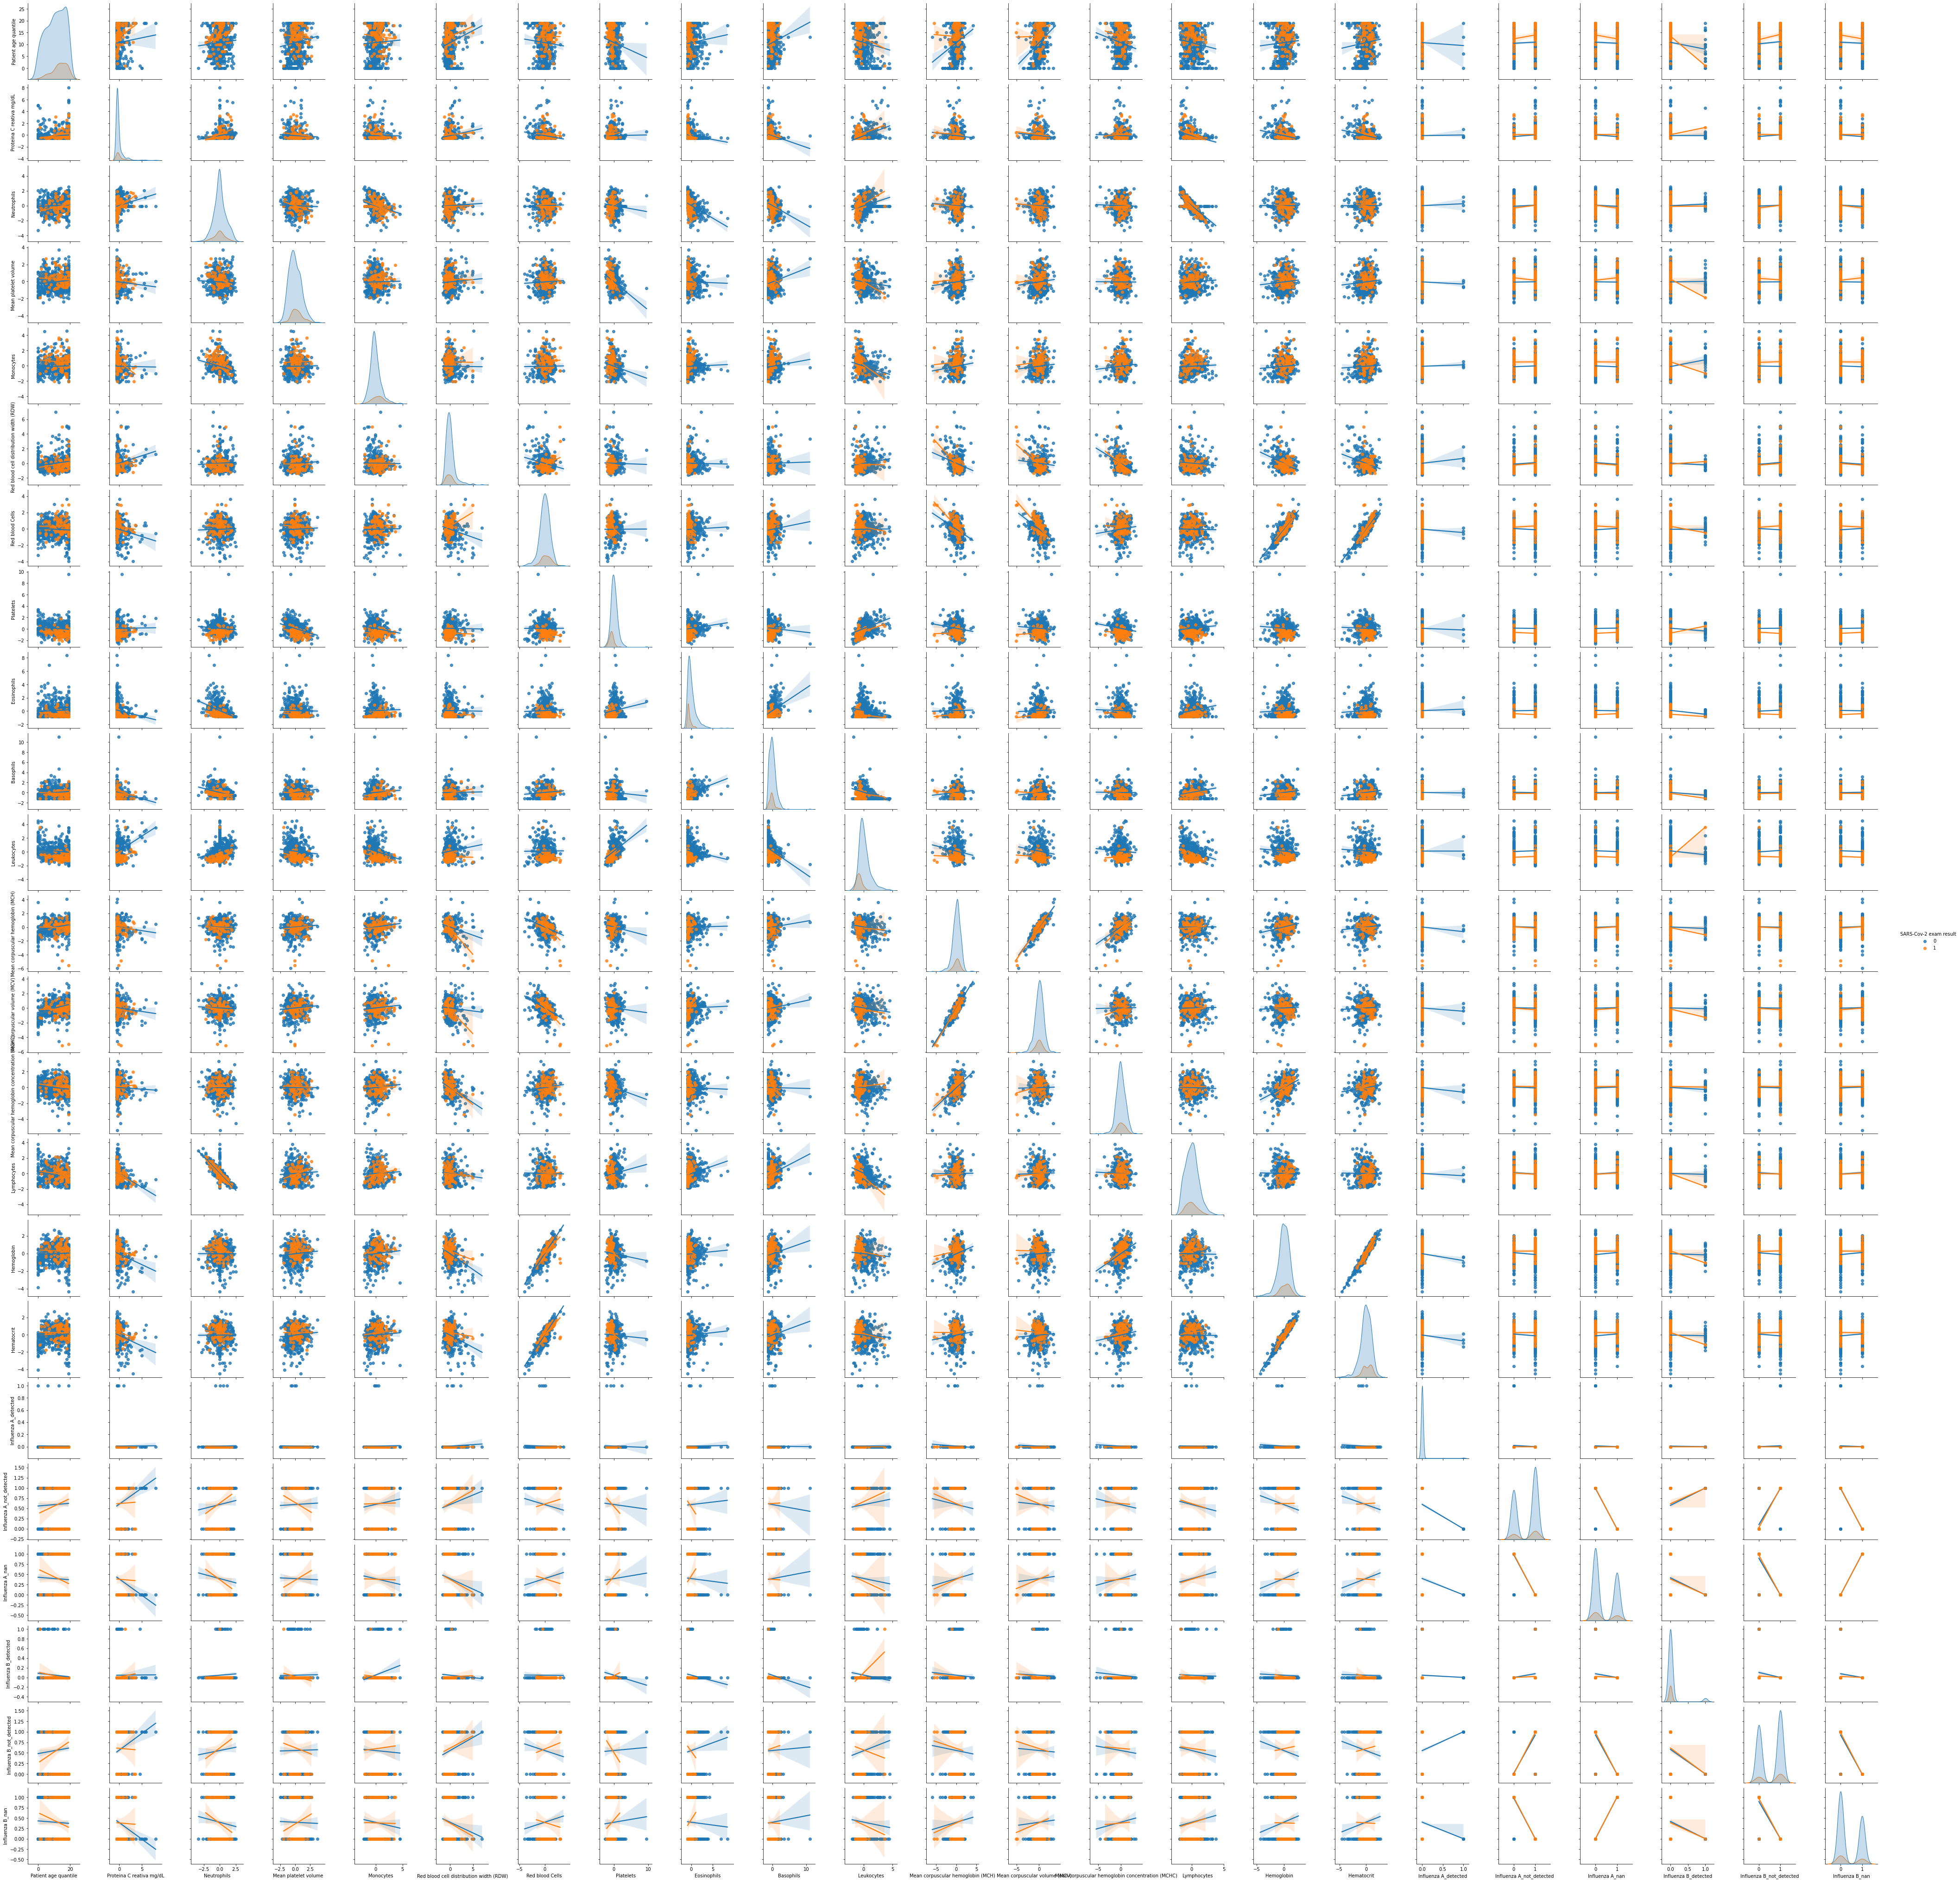

In [19]:
# What are the takeaways from this? Similar linear relationships / similar distributions?

sns.pairplot(brazil_enc, hue="SARS-Cov-2 exam result", kind="reg")

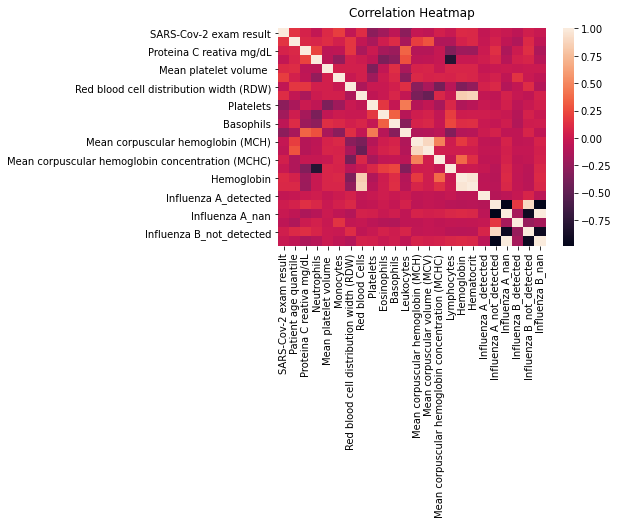

<Figure size 720x720 with 0 Axes>

In [20]:
heatmap = sns.heatmap(brazil_enc.corr())
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)
plt.figure(figsize=(10,10))
plt.show()

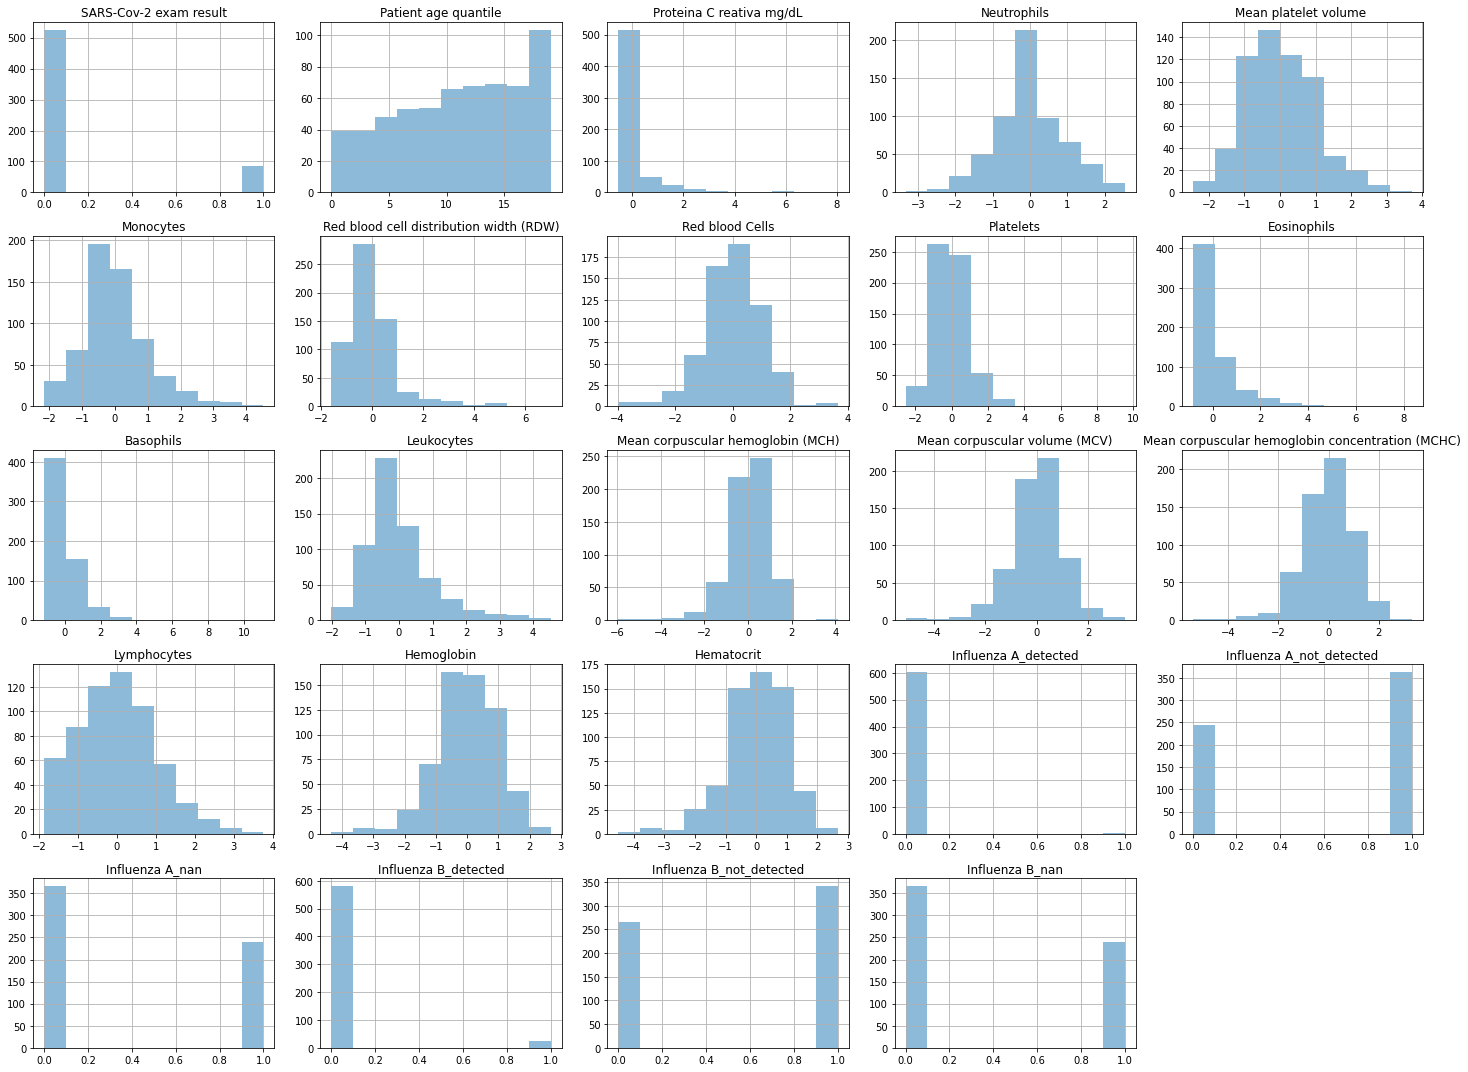

In [21]:
# Tight layout: https://stackoverflow.com/questions/52359595/how-to-change-the-space-between-histograms-in-pandas/52359774
# 1st cut of the data showed skewed distributions in RDW, Platelets, C protein, Basophils, Eosinophils

brazil_enc.hist(alpha=0.5, figsize=(20, 15))
plt.tight_layout()
plt.show()

# Investigating Supervised Classification Techniques

####  Objective:  Classification of Sars-Cov-2 cases using blood/flu test results

* Lecture notes quote the Multi-Layered Perceptron as a "natural extension" of a regression model

* Encompassed in the below: DecisionTree, LogisticRegression and MLP NeuralNet
* Performance metrics:  Precision, Recall, F1


In [22]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV

from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

rs = 10

def data_prep(brazil_enc):
    
    X_mat = brazil_enc.iloc[:,1:].values
    y = brazil_enc.iloc[:,0].values
    X_train, X_test, y_train, y_test = train_test_split(X_mat, y, test_size=0.3,  
                                                        stratify=y, random_state=rs)

    return X_train, X_test, y_train, y_test


## Data Preprocessing:  scaling using StandardScaler()

* Scaling applies to all models except CART Decision Trees
    * 
    * 
* LATER, neural networks may have difficulty converging before the maximum number of iterations allowed if the data is not normalized. 
* Multi-layer Perceptron networks in particular are sensitive to feature scaling, so it is highly recommended to scale your data. Note that you must apply the same scaling to the test set for meaningful results. There are a lot of different methods for normalization of data, we will use the built-in StandardScaler for standardization.

In [23]:
X_train, X_test, y_train, y_test = data_prep(brazil_enc)  #tuple unpacking above

# Creating the object StandardScaler(), which scales to a Normal-dist
scaler = StandardScaler()

# Confused on why we're putting both X_train and y_train in here???
X_train = scaler.fit_transform(X_train, y_train) 

X_test = scaler.transform(X_test)

## Building a Logistic Regression

##### Linear & Logistic Regression
Assumes a linear correlation between input features & target features
* (+)ve/(-)ve correlations to predicted values

In [24]:
# Build the model
model = LogisticRegression(random_state=rs)
model.fit(X_train, y_train)

# Get params, as defaults are not printing out like in the tutorials
model.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 10,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [25]:
# Assessing our Accuracy scores
print("Train accuracy:", model.score(X_train, y_train))
print("Test accuracy:", model.score(X_test, y_test))

# Classification report on test data
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# FN = Recall = 0.40, which is a poor result.  Due to lack of available data (Support=25)

# Accuracy = (TP + TN)/(TP + FP + TN + FN)

Train accuracy: 0.9033018867924528
Test accuracy: 0.8688524590163934
              precision    recall  f1-score   support

           0       0.91      0.94      0.93       158
           1       0.53      0.40      0.45        25

    accuracy                           0.87       183
   macro avg       0.72      0.67      0.69       183
weighted avg       0.86      0.87      0.86       183



In [26]:
print(classification_report(y_test, y_pred))

LR_base_accuracy = accuracy_score(y_test, y_pred)
print("Test accuracy: ", LR_base_accuracy)

              precision    recall  f1-score   support

           0       0.91      0.94      0.93       158
           1       0.53      0.40      0.45        25

    accuracy                           0.87       183
   macro avg       0.72      0.67      0.69       183
weighted avg       0.86      0.87      0.86       183

Test accuracy:  0.8688524590163934


### Summarizing the above output: 
* Training and Testing accuracy is HIGH (0.90 and 0.87), but 
* prediction values for Positive cases is LOW  (precision 0.53)
* #### Our focus for this trial is on RECALL = 0.4  (Recall = TP/(TP+FN))
    * indicating there are a relatively high number of False Negatives in comparison to correctly predicted cases


In [27]:
# Model Coefficients for our 23x features
print(model.coef_)


[[ 0.28359333  0.37380519 -1.04616667  0.00166612  0.06216141 -0.47083554
   0.46994463 -0.67304235 -1.59356296 -0.2441689  -1.32688496 -0.11295073
  -0.03343349 -0.03326073 -0.70637865  0.08717609  0.03628369 -0.24483952
   0.02408379  0.01806904 -0.4606105   0.19266717  0.01806904]]


#### Sorting variables:  Largest effect on the Logistic Model
* Eosinophils : -1.5936
* Leukocytes : -1.3269
* Neutrophils : -1.0462
* Lymphocytes : -0.7064
* Platelets : -0.673

In [28]:
# Sorting features into largest absolute effect on model (whilst preserving sign)

feature_names = brazil_enc.columns[1:]

coef = model.coef_[0].round(4)

indices = np.argsort(np.absolute(coef))
indices = np.flip(indices, axis=0)

for i in indices:
    print(feature_names[i], ':', coef[i])

Eosinophils : -1.5936
Leukocytes : -1.3269
Neutrophils : -1.0462
Lymphocytes : -0.7064
Platelets : -0.673
Red blood cell distribution width (RDW) : -0.4708
Red blood Cells : 0.4699
Influenza B_detected : -0.4606
Proteina C reativa mg/dL : 0.3738
Patient age quantile : 0.2836
Influenza A_detected : -0.2448
Basophils : -0.2442
Influenza B_not_detected : 0.1927
Mean corpuscular hemoglobin (MCH) : -0.113
Hemoglobin : 0.0872
Monocytes : 0.0622
Hematocrit : 0.0363
Mean corpuscular volume (MCV) : -0.0334
Mean corpuscular hemoglobin concentration (MCHC) : -0.0333
Influenza A_not_detected : 0.0241
Influenza A_nan : 0.0181
Influenza B_nan : 0.0181
Mean platelet volume  : 0.0017


### Hyperparameter Tuning with GridCV
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

Common parameters to tune: 
* <b>C:  inv(RegularizationStrength)</b> ~(10^-6 to 10^4 in log(10) order)
    * `'C': [pow(10,x) for x in range(-6,4)]`}
    * <b>Regularization  </b>[link](https://www.quora.com/What-is-regularization-in-machine-learning)
        * Regularization can be motivated as a technique to improve the generalizability of a learned model.
        * Regularization is a very important technique in machine learning to prevent overfitting. Mathematically speaking, it adds a regularization term in order to prevent the coefficients to fit so perfectly to overfit. The difference between the L1 and L2 is just that L2 is the sum of the square of the weights, while L1 is just the sum of the weights. 
        * Works by penalizing the Loss function L(X,Y) by adding a multiple of an L1 norm (LASSO) or L2 (Ridge) norm to weights vector, w  ==> 𝐿(𝑋,𝑌)+ 𝜆𝑁(𝑤)
        * (𝑁  is either the  𝐿1 , 𝐿2  or any other norm)
        * #### ARTICLE:  DIFFS between [𝐿1,𝐿2 Regularization](http://www.chioka.in/differences-between-l1-and-l2-as-loss-function-and-regularization/)
            * L1 regularization on least squares:
           ![image.png](http://www.chioka.in/wp-content/uploads/2013/12/least_squares_l11.png)
                    * computationally IN-efficient on non-sparse cases
                    * sparse outputs
                    * built-in feature selection
            * L2 regularization on least-squares
        ![](http://www.chioka.in/wp-content/uploads/2013/12/least_squares_l2.png)
                    * computationally efficient (due to having analytical solutions)
                    * non-sparse outputs
                    * no feature selection
        * 𝜆 is the regularization term
        * therefore it appears C = 1/𝜆
* <b>penalty in `[‘none’, ‘l1’, ‘l2’, ‘elasticnet’]`</b>
    * Used to specify the norm used in the penalization. The ‘newton-cg’, ‘sag’ and ‘lbfgs’ solvers support only l2 penalties. ‘elasticnet’ is only supported by the ‘saga’ solver. If ‘none’ (not supported by the liblinear solver), no regularization is applied.
* <b>solver in `[‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’]`</b>
    * For small datasets, ‘liblinear’ is a good choice, whereas ‘sag’ and ‘saga’ are faster for large ones.
    * For multiclass problems, only ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’ handle multinomial loss; ‘liblinear’ is limited to one-versus-rest schemes.
    * ‘newton-cg’, ‘lbfgs’, ‘sag’ and ‘saga’ handle L2 or no penalty
    * ‘liblinear’ and ‘saga’ also handle L1 penalty
    * ‘saga’ also supports ‘elasticnet’ penalty
    * ‘liblinear’ does not support setting penalty='none'
    * Note that ‘sag’ and ‘saga’ fast convergence is only guaranteed on features with approximately the same scale. You can preprocess the data with a scaler from sklearn.preprocessing.




### Fitting the GridSearchCV on a Logistic Regression model

In [29]:
%time

# C is the only hyperparameter => hence, num_models is equal to the range of vals(=9)
params = {'C': [pow(10, x) for x in range(-6, 4)]}  # C = 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000


cv_log = GridSearchCV(param_grid=params, 
                  estimator=LogisticRegression(random_state=rs),
                  return_train_score=True, cv=10, n_jobs=-1)
cv_log.fit(X_train, y_train)

CPU times: user 6 µs, sys: 1 µs, total: 7 µs
Wall time: 13.1 µs


GridSearchCV(cv=10, estimator=LogisticRegression(random_state=10), n_jobs=-1,
             param_grid={'C': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10,
                               100, 1000]},
             return_train_score=True)

In [30]:
# Just having a look at the results that are returned 
cv_log_results = cv_log.cv_results_
print(cv_log_results)

{'mean_fit_time': array([0.04021814, 0.03832903, 0.03189702, 0.02280207, 0.02041352,
       0.02552421, 0.05524495, 0.1034651 , 0.16434767, 0.15515656]), 'std_fit_time': array([0.00701716, 0.01345526, 0.01004915, 0.00743539, 0.00613336,
       0.00595719, 0.00843415, 0.02141177, 0.01669024, 0.01787663]), 'mean_score_time': array([0.00169268, 0.00206792, 0.00129704, 0.00191774, 0.00183856,
       0.00150049, 0.00109782, 0.00157855, 0.00123315, 0.00119271]), 'std_score_time': array([0.00104206, 0.00179913, 0.00054028, 0.00190447, 0.00121566,
       0.00112329, 0.00022627, 0.00123733, 0.00012822, 0.00062918]), 'param_C': masked_array(data=[1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                   1000],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object), 'params': [{'C': 1e-06}, {'C': 1e-05}, {'C': 0.0001}, {'C': 0.001}, {'C': 0.01}, {'C': 0.1}, {'C': 1}, {'C': 10}, {'C'

Total number of models:  10
The optimal value of C is: 10


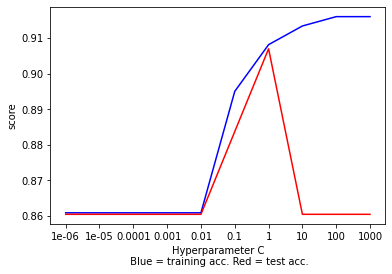

Train accuracy: 0.90802
Test accuracy:  0.87432
              precision    recall  f1-score   support

           0       0.91      0.94      0.93       158
           1       0.53      0.40      0.45        25

    accuracy                           0.87       183
   macro avg       0.72      0.67      0.69       183
weighted avg       0.86      0.87      0.86       183



In [31]:
## Testing results on the 1st CV split, split_0

cv_log_train_result = cv_log_results['split0_train_score']
cv_log_test_result = cv_log_results['split0_test_score']
print("Total number of models: ", len(cv_log_train_result))
print("The optimal value of C is:", cv_log.best_params_["C"])

# range(0, len(cv_log_train_result)),
# range(0, len(cv_log_test_result))

# plot Hyperparameter C values vs training and test accuracy score
plt.plot(cv_log_train_result, 'b', 
         cv_log_test_result, 'r')
plt.xlabel('Hyperparameter C\n Blue = training acc. Red = test acc.')
plt.xticks(range(0, len(cv_log_train_result)),[pow(10, x) for x in range(-6, 4)])
plt.ylabel('score')
plt.show()

cv_log.fit(X_train, y_train)

print("Train accuracy:", cv_log.score(X_train, y_train).round(5))
print("Test accuracy: ", cv_log.score(X_test, y_test).round(5))

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

#### How to interpret these two chart above/below?  Unclear from tute...
* Which would we choose?   THE TRAIN/TEST ACCURACY IS CLOSEST WHEN C=1


Total number of models:  10
The optimal value of C is: 10


Train accuracy: 0.90802
Test accuracy:  0.87432
              precision    recall  f1-score   support

           0       0.91      0.94      0.93       158
           1       0.55      0.44      0.49        25

    accuracy                           0.87       183
   macro avg       0.73      0.69      0.71       183
weighted avg       0.86      0.87      0.87       183



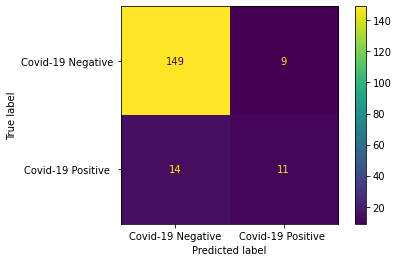

In [42]:
# Testing results on the Mean CV results

cv_log_train_result = cv_log_results['mean_train_score']
cv_log_test_result = cv_log_results['mean_test_score']
print("Total number of models: ", len(cv_log_test_result))
print("The optimal value of C is:", cv_log.best_params_["C"])

# plot Hyperparameter C values vs training and test accuracy score
plt.plot(cv_log_train_result, 'b', 
         cv_log_test_result, 'r')
plt.xlabel('Hyperparameter C\n Blue = training acc. Red = test acc.')
plt.xticks(range(0, len(cv_log_train_result)),[pow(10, x) for x in range(-6, 4)])
plt.ylabel('score')
plt.show()

cv_log.fit(X_train, y_train)

print("Train accuracy:", cv_log.score(X_train, y_train).round(5))
print("Test accuracy: ", cv_log.score(X_test, y_test).round(5))

y_pred = cv_log.predict(X_test)
print(classification_report(y_test, y_pred))
plot_confusion_matrix(cv_log,X_test,y_test,
                      display_labels=["Covid-19 Negative","Covid-19 Positive "])


In [43]:
# Coefficients of the GridSearchCV regression (C=10)
cv_log.best_estimator_.coef_

array([[ 0.28962578,  0.40623204, -1.46324212, -0.01617844, -0.01072735,
        -0.5743364 ,  1.50146697, -0.70440072, -1.95471338, -0.20414015,
        -1.47523181, -0.35587172,  0.71361384,  0.06841197, -1.07660435,
         0.0506814 , -0.77234984, -0.37444129,  0.0409069 ,  0.02354489,
        -0.5202944 ,  0.21456102,  0.02354489]])

In [241]:
cols = brazil_enc.columns[1:]
cols

Index(['Patient age quantile', 'Proteina C reativa mg/dL', 'Neutrophils',
       'Mean platelet volume ', 'Monocytes',
       'Red blood cell distribution width (RDW)', 'Red blood Cells',
       'Platelets', 'Eosinophils', 'Basophils', 'Leukocytes',
       'Mean corpuscular hemoglobin (MCH)', 'Mean corpuscular volume (MCV)',
       'Mean corpuscular hemoglobin concentration (MCHC)', 'Lymphocytes',
       'Hemoglobin', 'Hematocrit', 'Influenza A_detected',
       'Influenza A_not_detected', 'Influenza A_nan', 'Influenza B_detected',
       'Influenza B_not_detected', 'Influenza B_nan'],
      dtype='object')

### Feature Importance:  GridSearchCV Logistic Regression

In [254]:
cv_logT = pd.DataFrame(cv_log.best_estimator_.coef_.transpose())
GSCV_log_features = pd.DataFrame(cols)
GSCV_log_features["GSCV_coef"] = cv_logT
GSCV_log_features.sort_values("GSCV_coef", axis=0,ascending=False, inplace=True)
GSCV_log_features.head()

0  GSCV_coef
6                 Red blood Cells   1.501467
12  Mean corpuscular volume (MCV)   0.713614
1        Proteina C reativa mg/dL   0.406232
0            Patient age quantile   0.289626
21       Influenza B_not_detected   0.214561

In [253]:
GSCV_log_features.tail(5)

0  GSCV_coef
16   Hematocrit  -0.772350
14  Lymphocytes  -1.076604
2   Neutrophils  -1.463242
10   Leukocytes  -1.475232
8   Eosinophils  -1.954713

### The optimal "C" inverse regularization hyperparam = 10

### Feature Selection & Extraction (Dimensionality Reduction)

<b>Method 1: Recursive Feature Elimination (RFE)</b>
* RFE works by first training the model on all features. 
* Each feature is assigned a weight. 
* Features with small weights (less important are eliminated, making a smaller feature set. 
* This process is repeated a number of times until reaching the optimal performance.

In this activity, we will use RFE with cross validation (CV). Cross validation allows RFE to generalise better over a set of training datasets. RFE with CV is implemented in sklearn under
sklearn.feature_selection.RFECV . 
* Initiate the RFE with a logistic regression estimator and 10-fold CV to start eliminating features.





In [33]:
%time
# from sklearn.feature_selection import RFECV (import shifted to main section)

rfe = RFECV(estimator = LogisticRegression(random_state=rs), cv=10)
rfe.fit(X_train, y_train)  # runs the RFECV

# comparing how many variables before and after
print("Original feature set", X_train.shape[1])
print("Number of features after elimination", rfe.n_features_)


CPU times: user 10 µs, sys: 2 µs, total: 12 µs
Wall time: 12.2 µs
Original feature set 23
Number of features after elimination 15


## Which features were selected?

In [74]:
for i in range(X_train.shape[1]):
    print('Column: %d, Selected %s, Rank: %.3f' % (i, rfe.support_[i], rfe.ranking_[i]))

Column: 0, Selected True, Rank: 1.000
Column: 1, Selected True, Rank: 1.000
Column: 2, Selected True, Rank: 1.000
Column: 3, Selected False, Rank: 9.000
Column: 4, Selected False, Rank: 2.000
Column: 5, Selected True, Rank: 1.000
Column: 6, Selected True, Rank: 1.000
Column: 7, Selected True, Rank: 1.000
Column: 8, Selected True, Rank: 1.000
Column: 9, Selected True, Rank: 1.000
Column: 10, Selected True, Rank: 1.000
Column: 11, Selected True, Rank: 1.000
Column: 12, Selected False, Rank: 4.000
Column: 13, Selected False, Rank: 5.000
Column: 14, Selected True, Rank: 1.000
Column: 15, Selected True, Rank: 1.000
Column: 16, Selected False, Rank: 3.000
Column: 17, Selected True, Rank: 1.000
Column: 18, Selected False, Rank: 7.000
Column: 19, Selected False, Rank: 6.000
Column: 20, Selected True, Rank: 1.000
Column: 21, Selected True, Rank: 1.000
Column: 22, Selected False, Rank: 8.000


The RFE+CV process has eliminated 8 features, for an optimal set of 15. 

Transforming the original RFECV estimator on the inputs, and running another GridSearch :–

Train accuracy: 0.908
Test accuracy: 0.8743
              precision    recall  f1-score   support

           0       0.91      0.94      0.93       158
           1       0.55      0.44      0.49        25

    accuracy                           0.87       183
   macro avg       0.73      0.69      0.71       183
weighted avg       0.86      0.87      0.87       183

RFECV Best Parameters:  {'C': 100}


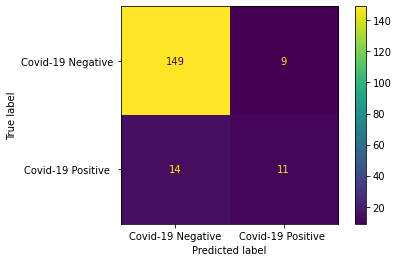

In [48]:
X_train_sel = rfe.transform(X_train)
X_test_sel = rfe.transform(X_test)

# grid search CV
params = {'C': [pow(10, x) for x in range(-6, 4)]}

rfe_cv = GridSearchCV(param_grid=params, 
                      estimator=LogisticRegression(random_state=rs), 
                      cv=10, n_jobs=-1)

rfe_cv.fit(X_train_sel, y_train)

# test the best model
print("Train accuracy:", rfe_cv.score(X_train_sel, y_train).round(4))
print("Test accuracy:", rfe_cv.score(X_test_sel, y_test).round(4))

y_pred = rfe_cv.predict(X_test_sel)
print(classification_report(y_test, y_pred))

# print parameters of the best model
print("RFECV Best Parameters: ",rfe_cv.best_params_)


plot_confusion_matrix(rfe_cv,X_test_sel,y_test,
                      display_labels=["Covid-19 Negative","Covid-19 Positive "])

In [50]:
# Testing results on the Mean CV results

rfe_cv_train_result = cv_log_results['mean_train_score']
rfe_cv_test_result = cv_log_results['mean_test_score']
print("Total number of models: ", len(rfe_cv_test_result))
print("The optimal value of C is:", rfe_cv.best_params_["C"])

# plot Hyperparameter C values vs training and test accuracy score
plt.plot(rfe_cv_train_result, 'b', 
         rfe_cv_test_result, 'r')
plt.xlabel('Hyperparameter C\n Blue = training acc. Red = test acc.')
plt.xticks(range(0, len(rfe_cv_train_result)),[pow(10, x) for x in range(-6, 4)])
plt.ylabel('score')
plt.show()

rfe_cv.fit(X_train_sel, y_train)

print("Train accuracy:", rfe_cv.score(X_train_sel, y_train).round(5))
print("Test accuracy: ", rfe_cv.score(X_test_sel, y_test).round(5))


Total number of models:  10
The optimal value of C is: 100


Train accuracy: 0.90802
Test accuracy:  0.87432


## Extracting the Model Coefficients

In [60]:
# Coefficients of the GridSearchCV regression (C=10)

print(rfe_cv.best_estimator_)
support_

print(rfe_cv.best_estimator_.coef_)

LogisticRegression(C=100, random_state=10)
[[ 0.30461943  0.40369222 -1.50663108 -0.57509833  1.63861559 -0.6844295
  -2.00513301 -0.20893049 -1.47613659  0.50217392 -1.10597694 -0.90375473
  -0.5398647  -0.52775084  0.2084598 ]]


In [182]:
rfe_log_coef = pd.DataFrame(rfe_cv.best_estimator_.coef_.transpose())
rfe_log_coef

0
0   0.304619
1   0.403692
2  -1.506631
3  -0.575098
4   1.638616
5  -0.684430
6  -2.005133
7  -0.208930
8  -1.476137
9   0.502174
10 -1.105977
11 -0.903755
12 -0.539865
13 -0.527751
14  0.208460

In [90]:
for i in range(X_train.shape[1]):
    print('Column: %d, Selected %s, Rank: %.3f' % (i, rfe.support_[i], rfe.ranking_[i]))

Column: 0, Selected True, Rank: 1.000
Column: 1, Selected True, Rank: 1.000
Column: 2, Selected True, Rank: 1.000
Column: 3, Selected False, Rank: 9.000
Column: 4, Selected False, Rank: 2.000
Column: 5, Selected True, Rank: 1.000
Column: 6, Selected True, Rank: 1.000
Column: 7, Selected True, Rank: 1.000
Column: 8, Selected True, Rank: 1.000
Column: 9, Selected True, Rank: 1.000
Column: 10, Selected True, Rank: 1.000
Column: 11, Selected True, Rank: 1.000
Column: 12, Selected False, Rank: 4.000
Column: 13, Selected False, Rank: 5.000
Column: 14, Selected True, Rank: 1.000
Column: 15, Selected True, Rank: 1.000
Column: 16, Selected False, Rank: 3.000
Column: 17, Selected True, Rank: 1.000
Column: 18, Selected False, Rank: 7.000
Column: 19, Selected False, Rank: 6.000
Column: 20, Selected True, Rank: 1.000
Column: 21, Selected True, Rank: 1.000
Column: 22, Selected False, Rank: 8.000


In [119]:
cols = brazil_enc.columns[1:]
cols

Index(['Patient age quantile', 'Proteina C reativa mg/dL', 'Neutrophils',
       'Mean platelet volume ', 'Monocytes',
       'Red blood cell distribution width (RDW)', 'Red blood Cells',
       'Platelets', 'Eosinophils', 'Basophils', 'Leukocytes',
       'Mean corpuscular hemoglobin (MCH)', 'Mean corpuscular volume (MCV)',
       'Mean corpuscular hemoglobin concentration (MCHC)', 'Lymphocytes',
       'Hemoglobin', 'Hematocrit', 'Influenza A_detected',
       'Influenza A_not_detected', 'Influenza A_nan', 'Influenza B_detected',
       'Influenza B_not_detected', 'Influenza B_nan'],
      dtype='object')

In [210]:
rfe_features = pd.DataFrame({"Features":cols,"Support":rfe.support_})
rfe_features.Support.value_counts()


True     15
False     8
Name: Support, dtype: int64

#### Data Wrangling to obtain RFECV Feature Importance

In [226]:
rfe_dummies = pd.get_dummies(rfe_features, columns=["Support"])
rfe3 = rfe_dummies[rfe_dummies["Support_True"]==1].copy()
rfe3.reset_index(drop=True, inplace=True)
#rfe3["Coeffs"] = rfe_log_coef
rfe3["RFECV_Coef"] = rfe_log_coef
rfe3.sort_values("RFECV_Coef",axis=0, ascending=False, inplace=True)
rfe3.drop(["Support_False","Support_True"],axis=1,inplace=True)
rfe3

Features  RFECV_Coef
4                           Red blood Cells    1.638616
9         Mean corpuscular hemoglobin (MCH)    0.502174
1                  Proteina C reativa mg/dL    0.403692
0                      Patient age quantile    0.304619
14                 Influenza B_not_detected    0.208460
7                                 Basophils   -0.208930
13                     Influenza B_detected   -0.527751
12                     Influenza A_detected   -0.539865
3   Red blood cell distribution width (RDW)   -0.575098
5                                 Platelets   -0.684430
11                               Hemoglobin   -0.903755
10                              Lymphocytes   -1.105977
8                                Leukocytes   -1.476137
2                               Neutrophils   -1.506631
6                               Eosinophils   -2.005133

In [227]:
rfe3.head(5)

Features  RFECV_Coef
4                     Red blood Cells    1.638616
9   Mean corpuscular hemoglobin (MCH)    0.502174
1            Proteina C reativa mg/dL    0.403692
0                Patient age quantile    0.304619
14           Influenza B_not_detected    0.208460

In [229]:
rfe3.tail(5)

Features  RFECV_Coef
11   Hemoglobin   -0.903755
10  Lymphocytes   -1.105977
8    Leukocytes   -1.476137
2   Neutrophils   -1.506631
6   Eosinophils   -2.005133

#### No meaningful difference for Train/Test accuracy appears to exist
* Shorter execution time:  wall time -50%, sys time reduced by 700% to 2 µs
* Find some additional info on how this scales


### Comparison of Logistic Regression models, named:
1. model
2. cv_log
3. rfe_cv

In [80]:
from sklearn.metrics import roc_auc_score

y_pred_proba_lr = model.predict_proba(X_test)
y_pred_proba_lr_cv = cv_log.predict_proba(X_test)
y_pred_proba_rfe_cv = rfe_cv.predict_proba(X_test_sel)

# Logistic with DecisionTree:  **MAYBE ADD THIS IN ALSO**
# y_pred_proba_cv_sel_model = cv_sel_model.predict_proba(X_test_sel_model)

roc_index_lr = roc_auc_score(y_test, y_pred_proba_lr[:, 1])
roc_index_lr_cv = roc_auc_score(y_test, y_pred_proba_lr_cv[:, 1])
roc_index_rfe_cv = roc_auc_score(y_test, y_pred_proba_rfe_cv[:, 1])
# roc_index_cv_sel_model = roc_auc_score(y_test, y_pred_proba_cv_sel_model[:, 1])

print("ROC index on test for `model`: ", roc_index_lr.round(4))
print("ROC index on test for `cv_log`:", roc_index_lr_cv.round(4))
print("ROC index on test for `rfe_cv`:", roc_index_rfe_cv.round(4))
# print("ROC index on test for `cv_sel_model`:", roc_index_cv_sel_model)

ROC index on test for `model`:  0.8691
ROC index on test for `cv_log`: 0.8633
ROC index on test for `rfe_cv`: 0.8615


In [81]:
from sklearn.metrics import roc_curve

fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_pred_proba_lr[:,1])
fpr_lr_cv, tpr_lr_cv, thresholds_lr_cv = roc_curve(y_test, y_pred_proba_lr_cv[:,1])
fpr_rfe_cv, tpr_rfe_cv, thresholds_rfe_cv = roc_curve(y_test, y_pred_proba_rfe_cv[:,1])
# fpr_cv_sel_model, tpr_cv_sel_model, thresholds_cv_sel_model = roc_curve(y_test, y_pred_proba_cv_sel_model[:,1])


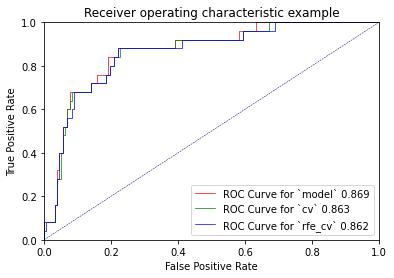

In [82]:
## import matplotlib.pyplot as plt

## Charting the ROC curve

plt.plot(fpr_lr, tpr_lr, label='ROC Curve for `model` {:.3f}'.format(roc_index_lr), color='red', lw=0.7)
plt.plot(fpr_lr_cv, tpr_lr_cv, label='ROC Curve for `cv` {:.3f}'.format(roc_index_lr_cv), color='green', lw=0.7)
plt.plot(fpr_rfe_cv, tpr_rfe_cv, label='ROC Curve for `rfe_cv` {:.3f}'.format(roc_index_rfe_cv), color='blue', lw=0.7)
#plt.plot(fpr_cv_sel_model, tpr_cv_sel_model, label='ROC Curve for `cv_sel_model` {:.3f}'.format(roc_index_cv_sel_model), color='yellow', lw=0.5)

# AREA UNDER ROC CURVE: 

plt.plot([0, 1], [0, 1], color='navy', lw=0.5, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### According to ROC curve, the logistic model with no tuning performs best
* To save the output, we need to use the pickle serialization libary

In [123]:
# Reluctantly setting the best performing model (ROC) to `model`

# Creates a file called LR.pickle in the directory

import pickle
lr_best = model
roc_index_lr_best = roc_index_lr
tpr_lr_best = tpr_lr
fpr_lr_best = fpr_lr
with open('LR.pickle', 'wb') as f:
    pickle.dump([lr_best,roc_index_lr_best, fpr_lr_best, tpr_lr_best], f)

# Building a Neural Network Model

#### Let's train our first MLPClassifier. 
1. Initiate the model without any additional parameter (other than the random state for consistency), and 
2. fit it to the training data and test its performance on the test data.

    * MLPClassifier trains iteratively since at each time step the *partial derivatives of the loss function with respect to the model parameters* are computed to update the parameters.

    * It can also have a regularization term added to the loss function that shrinks model parameters to prevent overfitting.

    * This implementation works with data represented as dense numpy arrays or sparse scipy arrays of floating point values.


In [261]:
#  MLP Classifier.

model_1 = MLPClassifier(random_state=rs)  # Input param: verbose=True  to see iterations
model_1.fit(X_train, y_train)

print("Train accuracy:", model_1.score(X_train, y_train).round(4))
print("Test accuracy:", model_1.score(X_test, y_test).round(4))

y_pred = model_1.predict(X_test) 
print(classification_report(y_test, y_pred))

plot_confusion_matrix(model_1,X_test,y_test,
                      display_labels=["Covid-19 Negative","Covid-19 Positive "])

print(model_1, "\n\nMLP Defaults: ", model_1.get_params())



/Users/DougNewton/Coding/DXM/Final/venv/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Train accuracy: 0.9623
Test accuracy: 0.8743
              precision    recall  f1-score   support

           0       0.93      0.92      0.93       158
           1       0.54      0.56      0.55        25

    accuracy                           0.87       183
   macro avg       0.73      0.74      0.74       183
weighted avg       0.88      0.87      0.88       183

MLPClassifier(random_state=10) 

MLP Defaults:  {'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 200, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 10, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}


### Results
* #### Training accuracy: 0.962   |   Test accuracy:  0.874  |  Recall = 0.56
   * Concerns about overfitting
   * Convergence warning:  max(iterations) exceeded at default=200
       * AIM:  increase the iterations, up to a limit of say 1000
       * IF warning persists:  this may indicate a problem with error computation
       
####  Re-execute with max_iter=800 to remove convergence warning

In [262]:
#  MLP Classifier(max_iter=800)

model_2 = MLPClassifier(max_iter=800, random_state=rs)  # Input param: verbose=True  to see iterations
model_2.fit(X_train, y_train)

print("Train accuracy:", model_2.score(X_train, y_train).round(3))
print("Test accuracy:", model_2.score(X_test, y_test).round(3))

y_pred = model_2.predict(X_test) 
print(classification_report(y_test, y_pred))
print(model_2, "\n\nMLP Defaults: ", model_2.get_params())



Train accuracy: 1.0
Test accuracy: 0.847
              precision    recall  f1-score   support

           0       0.93      0.89      0.91       158
           1       0.45      0.56      0.50        25

    accuracy                           0.85       183
   macro avg       0.69      0.73      0.70       183
weighted avg       0.86      0.85      0.85       183

MLPClassifier(max_iter=800, random_state=10) 

MLP Defaults:  {'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 800, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 10, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}


* #### Training accuracy increases to 1.0, whereas Test accuracy actually decreases to 0.847
    * #### This implies MODEL OVERFITTING
   
NEXT STEPS:  To use GridSearch tuning and Dimensionality Reduction techniques to control the overfitting of the model to the training data

<b> Weights SOLVER algorithm </b>:  variants of Stochastic Gradient Descent (SGD)
* finding the best combination of weights in neural networks is a significant search problem. The algorithm used to find this optimal weight set is called solver in sklearn, and the most common one is Gradient Descent.
* Gradient descent starts with a set of randomly generated weights. In each iteration of gradient descent, predictions are made on X_train and the error value (cost) is computed. The weight set is then altered to reduce this error value. Each iteration is called an epoch.
*  To stop gradient descent iterations, a strategy such as maximum iterations, minimum error threshold or convergence reached (error is not improved over a certain number of epochs) is used. <b>A combination of max iterations and convergence is the most commonly used criterion.</b>

MLP Classifier Hyperparameters:  "Solver=<b>adam</b>" stands for "adaptive moment estimation", with is a more computationally efficient version of Gradient Descent (speeding up the training process)
[ML Mastery article on ADAM](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)

Another important hyperparameter to observe is `activation`, which refers to activation function used in hidden layers of the neural network. There are a number of options to use, including:
* **identity**: $f(x) = x$, no transformation, uncommon
* **tanh**: $f(x) = {tanh}(x)$
* **sigmoid**: $f(x) = \frac{1}{1 + e^{h(\theta, x)}}$, commonly used in logistic regression
* **relu - rectified linear unit**: $f(x) = max(x,0)$, default option in sklearn





## 3. Finding optimal hyperparameter with GridSearchCV

Next we will find the optimal hyperparameters using GridSearchCV. Neural network is harder to tune than decision trees or regression models due to relatively many types of parameters and the slow training process. In this practical, we will focus on tuning two parameters:
1. `hidden_layer_sizes`: It has values of tuples, and within each tuple, element i-th represents the number of neurons contained in each hidden layer.
2. `alpha`: L2 regularization parameter used in each neuron's activation function.

Let us start by tuning the hidden layer sizes. There is no official guideline on how many neurons we should have in each layer, <font color='blue'>but for most data mining tasks a single hidden layer with neurons no more than the number of input variables and no less than output neurons (binary classification task, hence 1)</font> is sufficient.

> #### Deep Learning
> In the past decade, deep learning models have become highly popular. Deep learning is a process of building very complex neural networks (up to hundreds of layers and thousands of neurons, hence **deep**). Deep neural networks are typically used for complex tasks, like image recognition, Siri-like voice assistant, machine translation and self-driving tasks.

See how many input features we have by printing out the train shape.

In [85]:
# Training set, 70% of the data (0.7*607) and 23 features
X_train.shape

(424, 23)

#### Instructions: 
* 23 features, so we will start by tuning one hidden layer of 2 to 23 neurons, incrementing by 2 neurons at a time
* Tips: Setting the `max_iter` to a higher value (say 700) can complete the GridSearchCV without the convergence warning. However, the process will be expensive and take more time to complete.
* <b> HERE WE'RE ESSENTIALLY RUNNING GRIDSEARCHCV OVER THE DEFAULT NN

In [263]:
## Running params through hidden layer sizes: 1 to 23 
params = {'hidden_layer_sizes': [(x,) for x in range(2, 24, 2)]} 

%timeit
cv_1 = GridSearchCV(param_grid=params, 
                    estimator=MLPClassifier(max_iter=800, random_state=rs),
                    return_train_score=True, cv=10, n_jobs=-1)
cv_1.fit(X_train, y_train)

result_set = cv_1.cv_results_

# Model params did not output like in tutorials
print(cv_1.get_params())

{'cv': 10, 'error_score': nan, 'estimator__activation': 'relu', 'estimator__alpha': 0.0001, 'estimator__batch_size': 'auto', 'estimator__beta_1': 0.9, 'estimator__beta_2': 0.999, 'estimator__early_stopping': False, 'estimator__epsilon': 1e-08, 'estimator__hidden_layer_sizes': (100,), 'estimator__learning_rate': 'constant', 'estimator__learning_rate_init': 0.001, 'estimator__max_fun': 15000, 'estimator__max_iter': 800, 'estimator__momentum': 0.9, 'estimator__n_iter_no_change': 10, 'estimator__nesterovs_momentum': True, 'estimator__power_t': 0.5, 'estimator__random_state': 10, 'estimator__shuffle': True, 'estimator__solver': 'adam', 'estimator__tol': 0.0001, 'estimator__validation_fraction': 0.1, 'estimator__verbose': False, 'estimator__warm_start': False, 'estimator': MLPClassifier(max_iter=800, random_state=10), 'iid': 'deprecated', 'n_jobs': -1, 'param_grid': {'hidden_layer_sizes': [(2,), (4,), (6,), (8,), (10,), (12,), (14,), (16,), (18,), (20,), (22,)]}, 'pre_dispatch': '2*n_jobs', 

/Users/DougNewton/Coding/DXM/Final/venv/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [94]:
print(result_set)

{'mean_fit_time': array([ 3.21715369,  4.67716212,  4.99404454,  7.65816627,  9.06209478,
        9.94926724, 10.38356071, 11.20669863,  8.57199984,  8.31345344,
        8.46177638]), 'std_fit_time': array([0.64285745, 0.53653408, 0.50165062, 0.7954906 , 0.74798483,
       0.41467477, 0.52395564, 1.13733713, 0.57738347, 1.00718651,
       1.03845453]), 'mean_score_time': array([0.00160367, 0.00332348, 0.00226133, 0.00503414, 0.00419226,
       0.00304124, 0.00449767, 0.009571  , 0.00435007, 0.00320733,
       0.0026813 ]), 'std_score_time': array([0.00023586, 0.00265164, 0.00143524, 0.00677589, 0.00286478,
       0.00234871, 0.00477311, 0.00717342, 0.00275621, 0.0030115 ,
       0.00268726]), 'param_hidden_layer_sizes': masked_array(data=[(2,), (4,), (6,), (8,), (10,), (12,), (14,), (16,),
                   (18,), (20,), (22,)],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False],
       fill_value='?',
            dtype=o

#### Assuming the CV=Cross-validation step,  plot the train and test scores of split0. 

Total number of models:  11


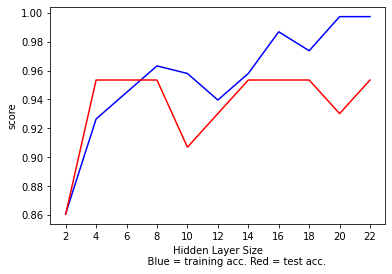

Train accuracy: 0.9623
Test accuracy: 0.8689
              precision    recall  f1-score   support

           0       0.92      0.93      0.92       158
           1       0.52      0.48      0.50        25

    accuracy                           0.87       183
   macro avg       0.72      0.71      0.71       183
weighted avg       0.86      0.87      0.87       183

{'hidden_layer_sizes': (8,)}


In [266]:
# We could loop through this to plot out every chart, OR, 
# The following chart below chooses mean values instead

import matplotlib.pyplot as plt
train_result = result_set['split0_train_score']
test_result = result_set['split0_test_score']
print("Total number of models: ", len(test_result))

# plot hidden layers hyperparameter values vs training and test accuracy score
plt.plot(range(0, len(train_result)), train_result, 'b', 
         range(0, len(test_result)), test_result, 'r')
plt.xlabel('Hidden Layer Size\n\
            Blue = training acc. Red = test acc.')
plt.xticks(range(0, len(train_result)),range(2, 24, 2)) # range(1, 23)
plt.ylabel('score')
plt.show()

print("Train accuracy:", cv_1.score(X_train, y_train).round(4))
print("Test accuracy:", cv_1.score(X_test, y_test).round(4))

y_pred = cv_1.predict(X_test)
print(classification_report(y_test, y_pred))

print(cv_1.best_params_)

#### Now, plot the mean train and test scores of all runs.

In [267]:
### Enter your code
train_result = result_set['mean_train_score']
test_result = result_set['mean_test_score']
print("Total number of models: ", len(test_result))

# plot hidden layers hyperparameter values vs training and test accuracy score
plt.plot(range(0, len(train_result)), train_result, 'b', 
         range(0,len(test_result)), test_result, 'r')
plt.xlabel('Hyperparameter Hidden_layers\n\
            Blue = training acc. Red = test acc.')
plt.xticks(range(0, len(train_result)),range(2, 24, 2)) # range(1, 23)

plt.ylabel('score')
plt.show()

#  cv_1 = GridSearchCV(param_grid=params, estimator=MLPClassifier(random_state=rs),
                    #  return_train_score=True, cv=10, n_jobs=-1)
#  cv_1.fit(X_train, y_train)

print("Train accuracy:", cv_1.score(X_train, y_train).round(4))
print("Test accuracy:", cv_1.score(X_test, y_test).round(4))

y_pred = cv_1.predict(X_test)
print(classification_report(y_test, y_pred))

print(cv_1.best_params_)

Total number of models:  11


Train accuracy: 0.9623
Test accuracy: 0.8689
              precision    recall  f1-score   support

           0       0.92      0.93      0.92       158
           1       0.52      0.48      0.50        25

    accuracy                           0.87       183
   macro avg       0.72      0.71      0.71       183
weighted avg       0.86      0.87      0.87       183

{'hidden_layer_sizes': (8,)}


The output of this GridSearchCV returns <b>8 neurons</b> as the optimal number of neurons in the hidden layer. 
* <b>Tute included this: </b>Based on the *performance of previous decision tree and regression models*, it seems the less complex models (smaller trees, smaller feature sets) tend to generalise better on this dataset. We should attempt to tune the model with the lower number of neurons in the hidden layer.

#### Re-test the neurons around hidden_layer_size = 8



#### Reducing neuron/feature layers

In [278]:
# Manually altering hidden layer sizes around the optimal 8 output above

params = {'hidden_layer_sizes': [(6,),(7,),(8,),(9,),(10,),(11,)]}

cv_2 = GridSearchCV(param_grid=params, 
                    estimator=MLPClassifier(random_state=rs), 
                    return_train_score=True,
                    cv=10, n_jobs=-1)
cv_2.fit(X_train, y_train)

result_set2 = cv_2.cv_results_

# Model params did not output like in tutorials
print(cv_2.get_params())

{'cv': 10, 'error_score': nan, 'estimator__activation': 'relu', 'estimator__alpha': 0.0001, 'estimator__batch_size': 'auto', 'estimator__beta_1': 0.9, 'estimator__beta_2': 0.999, 'estimator__early_stopping': False, 'estimator__epsilon': 1e-08, 'estimator__hidden_layer_sizes': (100,), 'estimator__learning_rate': 'constant', 'estimator__learning_rate_init': 0.001, 'estimator__max_fun': 15000, 'estimator__max_iter': 200, 'estimator__momentum': 0.9, 'estimator__n_iter_no_change': 10, 'estimator__nesterovs_momentum': True, 'estimator__power_t': 0.5, 'estimator__random_state': 10, 'estimator__shuffle': True, 'estimator__solver': 'adam', 'estimator__tol': 0.0001, 'estimator__validation_fraction': 0.1, 'estimator__verbose': False, 'estimator__warm_start': False, 'estimator': MLPClassifier(random_state=10), 'iid': 'deprecated', 'n_jobs': -1, 'param_grid': {'hidden_layer_sizes': [(6,), (7,), (8,), (9,), (10,), (11,)]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': True, 'scori

/Users/DougNewton/Coding/DXM/Final/venv/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Total number of models:  6


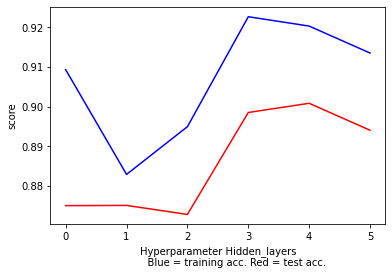

Train accuracy: 0.9198
Test accuracy: 0.8852
              precision    recall  f1-score   support

           0       0.92      0.96      0.93       158
           1       0.61      0.44      0.51        25

    accuracy                           0.89       183
   macro avg       0.76      0.70      0.72       183
weighted avg       0.87      0.89      0.88       183

{'hidden_layer_sizes': (10,)}


In [279]:
### Enter your code
train_result2 = result_set2['mean_train_score']
test_result2 = result_set2['mean_test_score']
print("Total number of models: ", len(test_result2))

# plot hidden layers hyperparameter values vs training and test accuracy score
plt.plot(range(0, len(train_result2)), train_result2, 'b', 
         range(0,len(test_result2)), test_result2, 'r')
plt.xlabel('Hyperparameter Hidden_layers\n\
            Blue = training acc. Red = test acc.')

plt.ylabel('score')
plt.show()

print("Train accuracy:", cv_2.score(X_train, y_train).round(4))
print("Test accuracy:", cv_2.score(X_test, y_test).round(4))

y_pred = cv_2.predict(X_test)
print(classification_report(y_test, y_pred))

print(cv_2.best_params_)

* #### We have an improvement in Test accuracy, whilst hidden layer size has inc to 10
* `{'hidden_layer_sizes': (10,)}`  :  Does this mean it is the best model?

### ADDING Learning Rate = Alpha as a Hyperparameter to tune

In [268]:
params = {'hidden_layer_sizes': [(x,) for x in range(8,12)], 
          'alpha': [100, 10, 1.0, 0.1, 0.01, 0.001, 0.0001]}
%timeit
cv_3 = GridSearchCV(param_grid=params, 
                    estimator=MLPClassifier(random_state=rs), 
                    return_train_score=True,
                    cv=10, n_jobs=-1)
cv_3.fit(X_train, y_train)

result_set3 = cv_3.cv_results_

print(cv_3.get_params())

{'cv': 10, 'error_score': nan, 'estimator__activation': 'relu', 'estimator__alpha': 0.0001, 'estimator__batch_size': 'auto', 'estimator__beta_1': 0.9, 'estimator__beta_2': 0.999, 'estimator__early_stopping': False, 'estimator__epsilon': 1e-08, 'estimator__hidden_layer_sizes': (100,), 'estimator__learning_rate': 'constant', 'estimator__learning_rate_init': 0.001, 'estimator__max_fun': 15000, 'estimator__max_iter': 200, 'estimator__momentum': 0.9, 'estimator__n_iter_no_change': 10, 'estimator__nesterovs_momentum': True, 'estimator__power_t': 0.5, 'estimator__random_state': 10, 'estimator__shuffle': True, 'estimator__solver': 'adam', 'estimator__tol': 0.0001, 'estimator__validation_fraction': 0.1, 'estimator__verbose': False, 'estimator__warm_start': False, 'estimator': MLPClassifier(random_state=10), 'iid': 'deprecated', 'n_jobs': -1, 'param_grid': {'hidden_layer_sizes': [(8,), (9,), (10,), (11,)], 'alpha': [100, 10, 1.0, 0.1, 0.01, 0.001, 0.0001]}, 'pre_dispatch': '2*n_jobs', 'refit': T

/Users/DougNewton/Coding/DXM/Final/venv/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Total number of models:  28


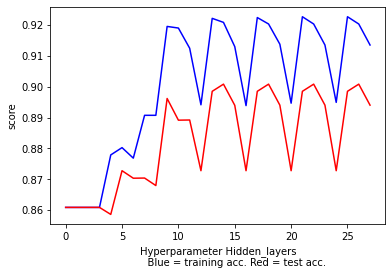

Train accuracy: 0.9198   |  Test accuracy: 0.8907
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       158
           1       0.63      0.48      0.55        25

    accuracy                           0.89       183
   macro avg       0.78      0.72      0.74       183
weighted avg       0.88      0.89      0.88       183

{'alpha': 0.1, 'hidden_layer_sizes': (10,)}


In [270]:
### Enter your code
train_result3 = result_set3['mean_train_score']
test_result3 = result_set3['mean_test_score']
print("Total number of models: ", len(test_result3))

# plot hidden layers hyperparameter values vs training and test accuracy score
plt.plot(range(0, len(train_result3)), train_result3, 'b', 
         range(0,len(test_result3)), test_result3, 'r')
plt.xlabel('Hyperparameter Hidden_layers\n\
            Blue = training acc. Red = test acc.')
plt.ylabel('score')
plt.show()

print("Train accuracy:", cv_3.score(X_train, y_train).round(4), "  |  Test accuracy:", cv_3.score(X_test, y_test).round(4))

y_pred = cv_3.predict(X_test)
print(classification_report(y_test, y_pred))

print(cv_3.best_params_)

plot_confusion_matrix(cv_3,X_test,y_test,
                      display_labels=["Covid-19 Negative","Covid-19 Positive "])

### Interpretation
* Model improved test accuracy yo 0.8907
* Estimator alpha has been optimized to 0.1 from 0.001
* Sticking with this result
* Weighted average Recall = 0.89, Recall (True) = 0.48
   


### Neural network architecture
Neural network techniques in general do not restrict the number of output nodes. There can be multiple outputs representing multiple simultaneous predictions (each prediction referring to a target variable). This is one way that neural nets differ from most other predictive techniques. The number of hidden nodes and layers is often increased with the number of inputs and the complexity of the problem. Too many hidden nodes can lead to overfitting and too few can result in models with underfitting (or poor accuracy).

### To prevent model overfitting

##### Neural networks:

* changing the number of nodes in the network (too many hidden nodes may result in overfitting)
* reducing the number of epochs in the training with additional epochs—the network may be learning the unique training data features instead of generalised characteristics
    * <b> How to achieve this in the assignment? </b>
* reducing the feature set
    * <b> Manually selecting the set? </b>
* using cross-validation
* using validation dataset to set parameters.

##### Decision tree:

* changing the decision tree setting such that a smaller size tree is built
* reducing the depth of a branch
* reducing the feature set
* pruning to chop the specific conditions set for training data only
* using cross-validation.

##### Regression functions:

* reducing the feature set
* cross-validation
* data quality improvement.

## 4. Dimensionality reduction
Next we will try to improve performance of the model through the dimensionality reduction and transformation techniques covered in the regression modelling practical.

### 4.1. Recursive Feature Elimination
We will first try to reduce the feature set size using RFE. We will need a base elimination model and RFE requires the type of model that assigns weight/feature importance to each feature (like regression/decision tree). Unfortunately, neural networks provide neither, thus we will try to use Logistic Regression as the base elimination model.

In [104]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

rfe = RFECV(estimator = LogisticRegression(random_state=rs), cv=10)
rfe.fit(X_train, y_train)

print(rfe.n_features_)

15


#### The RFE with logistic regression has selected 15 features as the best set of features. 
* With these selected features, tune an MLPClassifier model.

In [273]:
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

# step = int((X_train_rfe.shape[1] + 5)/5);
params = {'hidden_layer_sizes': [(x,) for x in range(8,12)], 
          'alpha': [1.0,0.1,0.01,0.01,0.001, 0.0001]}

rfe_nn_cv = GridSearchCV(param_grid=params, 
                         estimator=MLPClassifier(random_state=rs,max_iter=800),
                         return_train_score=True,
                      cv=10, n_jobs=-1)
rfe_nn_cv.fit(X_train_rfe, y_train)

result_set_rfe_nn_cv = rfe_nn_cv.cv_results_

print(rfe_nn_cv.get_params())



{'cv': 10, 'error_score': nan, 'estimator__activation': 'relu', 'estimator__alpha': 0.0001, 'estimator__batch_size': 'auto', 'estimator__beta_1': 0.9, 'estimator__beta_2': 0.999, 'estimator__early_stopping': False, 'estimator__epsilon': 1e-08, 'estimator__hidden_layer_sizes': (100,), 'estimator__learning_rate': 'constant', 'estimator__learning_rate_init': 0.001, 'estimator__max_fun': 15000, 'estimator__max_iter': 800, 'estimator__momentum': 0.9, 'estimator__n_iter_no_change': 10, 'estimator__nesterovs_momentum': True, 'estimator__power_t': 0.5, 'estimator__random_state': 10, 'estimator__shuffle': True, 'estimator__solver': 'adam', 'estimator__tol': 0.0001, 'estimator__validation_fraction': 0.1, 'estimator__verbose': False, 'estimator__warm_start': False, 'estimator': MLPClassifier(max_iter=800, random_state=10), 'iid': 'deprecated', 'n_jobs': -1, 'param_grid': {'hidden_layer_sizes': [(8,), (9,), (10,), (11,)], 'alpha': [1.0, 0.1, 0.01, 0.01, 0.001, 0.0001]}, 'pre_dispatch': '2*n_jobs',

In [276]:
### Enter your code
train_result_rfe_nn = result_set_rfe_nn_cv['mean_train_score']
test_result_rfe_nn = result_set_rfe_nn_cv['mean_test_score']
#print("Total number of models: ", len(test_result_rfe_nn))

# plot hidden layers hyperparameter values vs training and test accuracy score
#plt.plot(range(0, len(train_result_rfe_nn)), train_result_rfe_nn, 'b', 
#         range(0,len(test_result_rfe_nn)), test_result_rfe_nn, 'r')
#plt.xlabel('Hyperparameter Hidden_layers\n\
            #Blue = training acc. Red = test acc.')
#plt.ylabel('score')
#plt.show()

print("Train accuracy:", rfe_nn_cv.score(X_train_rfe, y_train).round(4))
print("Test accuracy:", rfe_nn_cv.score(X_test_rfe, y_test).round(4))

y_pred = rfe_nn_cv.predict(X_test_rfe)
print(classification_report(y_test, y_pred))

print(rfe_nn_cv.best_params_)

plot_confusion_matrix(rfe_nn_cv,X_test_rfe,y_test,
                      display_labels=["Covid-19 Negative","Covid-19 Positive "])
y_pred = rfe_nn_cv.predict(X_test_rfe)



Train accuracy: 0.9175
Test accuracy: 0.8743
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       158
           1       0.56      0.36      0.44        25

    accuracy                           0.87       183
   macro avg       0.73      0.66      0.68       183
weighted avg       0.86      0.87      0.86       183

{'alpha': 1.0, 'hidden_layer_sizes': (10,)}


# Comparison and finding the best performing model

A total of 9x models have been built  (10x including DTs)
1. Logistic regression (`model`)
2. Logistic regression + GridSearch (`cv_log`) tuning regularization parameter, 'C'
3. Logistic regression + Reduced Feature Eliminator + GridSearch (`rfe_cv`)
4. Multilayer perceptron neural network (`model_1`)
5. MLP NN, forcing convergence (`model_2`)
6. MLP NN + GridSearch on hidden_layer_size (`cv_1`)
7. MLP NN + GridSearch further tuning layers(`cv_2`)
8. MLP NN + GridSearch (introducing alpha learning rate) (`cv_3`)
9. RFE feeding into MLP NN + GridSearch (size, alpha) (`rfe_nn_cv`)
10. Optimal Decision Tree

## The RFE dimensionality reduction technique has resulted in a lower accuracy score

In [280]:
from sklearn.metrics import roc_auc_score

y_pred_proba_logreg = model.predict_proba(X_test)
y_pred_proba_cv_log = cv_log.predict_proba(X_test)
y_pred_proba_rfe_cv = rfe_cv.predict_proba(X_test_sel)
y_pred_proba_nn1 = model_1.predict_proba(X_test)
y_pred_proba_nn2 = model_2.predict_proba(X_test)
y_pred_proba_nn3_cv1 = cv_1.predict_proba(X_test)
y_pred_proba_nn4_cv2 = cv_2.predict_proba(X_test)
y_pred_proba_nn5_cv3 = cv_3.predict_proba(X_test)
y_pred_proba_nn6_rfe = rfe_nn_cv.predict_proba(X_test_rfe)


roc_index_logreg = roc_auc_score(y_test, y_pred_proba_logreg[:, 1])
roc_index_cv_log = roc_auc_score(y_test, y_pred_proba_cv_log[:, 1])
roc_index_rfe_cv = roc_auc_score(y_test, y_pred_proba_rfe_cv[:, 1])
roc_index_nn1 = roc_auc_score(y_test, y_pred_proba_nn1[:, 1])
roc_index_nn2 = roc_auc_score(y_test, y_pred_proba_nn2[:, 1])
roc_index_nn3_cv1 = roc_auc_score(y_test, y_pred_proba_nn3_cv1[:, 1])
roc_index_nn4_cv2 = roc_auc_score(y_test, y_pred_proba_nn4_cv2[:, 1])
roc_index_nn5_cv3 = roc_auc_score(y_test, y_pred_proba_nn5_cv3[:, 1])
roc_index_nn6_rfe = roc_auc_score(y_test, y_pred_proba_nn6_rfe[:, 1])


print("ROC index on test for Logistic regression (model):", roc_index_logreg.round(3))
print("ROC index on test for Logistic regression + GridSearch (cv_log) tuning 'C':", roc_index_cv_log.round(3))
print("ROC index on test for NN LogReg + Reduced Feature Eliminator + GridSearch (rfe_cv):", roc_index_rfe_cv.round(3))
print("ROC index on test for NN with MLP NN (model_1):", roc_index_nn1.round(3))
print("ROC index on test for NN with MLP NN + GridSearch on hidden_layer_size (cv_1):", roc_index_nn3_cv1.round(3))
print("ROC index on test for NN with MLP NN + GridSearch further tuning layers(cv_2):", roc_index_nn4_cv2.round(3))
print("ROC index on test for NN with MLP NN + GridSearch (tuning alpha) (`cv_3`):", roc_index_nn5_cv3.round(3))
print("ROC index on test for NN with RFE, MLP NN + GridSearch (size, alpha) (`rfe_nn_cv`):", roc_index_nn6_rfe.round(3))

from sklearn.metrics import roc_curve

fpr_logreg, tpr_logreg, thresholds_logreg = roc_curve(y_test, y_pred_proba_logreg[:,1])
fpr_cv_log, tpr_cv_log, thresholds_cv_log = roc_curve(y_test, y_pred_proba_cv_log[:,1])
fpr_rfe_cv, tpr_rfe_cv, thresholds_rfe_cv = roc_curve(y_test, y_pred_proba_rfe_cv[:,1])
fpr_nn1, tpr_nn1, thresholds_nn1 = roc_curve(y_test, y_pred_proba_nn1[:,1])
fpr_nn2, tpr_nn2, thresholds_nn2 = roc_curve(y_test, y_pred_proba_nn2[:,1])
fpr_nn3_cv1, tpr_nn3_cv1, thresholds_nn3_cv1 = roc_curve(y_test, y_pred_proba_nn3_cv1[:,1])
fpr_nn4_cv2, tpr_nn4_cv2, thresholds_nn4_cv2 = roc_curve(y_test, y_pred_proba_nn4_cv2[:, 1])
fpr_nn5_cv3, tpr_nn5_cv3, thresholds_nn5_cv3 = roc_curve(y_test, y_pred_proba_nn5_cv3[:, 1])
fpr_cv_nn6_rfe, tpr_cv_nn6_rfe, thresholds_cv_nn6_rfe = roc_curve(y_test, y_pred_proba_nn6_rfe[:, 1])

ROC index on test for Logistic regression (model): 0.869
ROC index on test for Logistic regression + GridSearch (cv_log) tuning 'C': 0.863
ROC index on test for NN LogReg + Reduced Feature Eliminator + GridSearch (rfe_cv): 0.862
ROC index on test for NN with MLP NN (model_1): 0.892
ROC index on test for NN with MLP NN + GridSearch on hidden_layer_size (cv_1): 0.893
ROC index on test for NN with MLP NN + GridSearch further tuning layers(cv_2): 0.899
ROC index on test for NN with MLP NN + GridSearch (tuning alpha) (`cv_3`): 0.899
ROC index on test for NN with RFE, MLP NN + GridSearch (size, alpha) (`rfe_nn_cv`): 0.886


In [281]:
import matplotlib.pyplot as plt

plt.plot(fpr_logreg, tpr_logreg, label='LogReg Default {:.3f}'.format(roc_index_logreg), color='red', lw=0.)
plt.plot(fpr_cv_log, tpr_cv_log, label='LogReg + GCV {:.3f}'.format(roc_index_cv_log), color='green', lw=0.5)
plt.plot(fpr_rfe_cv, tpr_rfe_cv, label='RFECV LogReg {:.3f}'.format(roc_index_rfe_cv), color='blue', lw=0.5)
plt.plot(fpr_nn1, tpr_nn1, label='MLP NN {:.3f}'.format(roc_index_nn1), color='yellow', lw=0.5)
plt.plot(fpr_nn2, tpr_nn2, label='MLP NN2 {:.3f}'.format(roc_index_nn2), color='cyan', lw=0.5)
plt.plot(fpr_nn3_cv1, tpr_nn3_cv1, label='NN3 GCV1 {:.3f}'.format(roc_index_nn3_cv1), color='gray', lw=0.5)
plt.plot(fpr_nn4_cv2, tpr_nn4_cv2, label='NN4 GCV2 {:.3f}'.format(roc_index_nn4_cv2), color='magenta', lw=0.7)
plt.plot(fpr_nn3_cv1, tpr_nn3_cv1, label='NN5 GCV3 alpha {:.3f}'.format(roc_index_nn5_cv3), color='orange', lw=3)
plt.plot(fpr_cv_nn6_rfe, tpr_cv_nn6_rfe, label='NN6 RFECV {:.3f}'.format(roc_index_nn6_rfe), color='brown', lw=0.5)


plt.plot([0, 1], [0, 1], color='navy', lw=0.5, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic, ROC AUC metrics')
plt.legend(loc="lower right")
plt.show()

### Importing our Optimized Decision Tree model 
* Assessing the optimal Decision Tree vs. Logistic Regression vs. MLP Network

* ### MLP Network with GridSearch tuning at Alpha=0.1, hidden layer size = 10 returns the best results


/Users/DougNewton/Coding/DXM/Final/venv/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.23.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/DougNewton/Coding/DXM/Final/venv/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator GridSearchCV from version 0.23.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


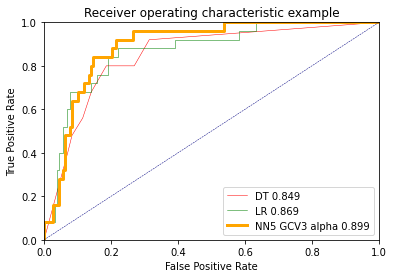

In [282]:
### Enter your code
import pickle
with open('DT.pickle', 'rb') as f:
    dt_best,roc_index_dt_cv, fpr_dt_cv, tpr_dt_cv = pickle.load(f)
with open('LR.pickle', 'rb') as f:
    lr_best,roc_index_lr_cv, fpr_lr_cv, tpr_lr_cv = pickle.load(f)   
    
plt.plot(fpr_dt_cv, tpr_dt_cv, label='DT {:.3f}'.format(roc_index_dt_cv), color='red', lw=0.5)
plt.plot(fpr_logreg, tpr_lr_cv, label='LR {:.3f}'.format(roc_index_lr_cv), color='green', lw=0.5)
plt.plot(fpr_nn3_cv1, tpr_nn3_cv1, label='NN5 GCV3 alpha {:.3f}'.format(roc_index_nn5_cv3), color='orange', lw=3)

plt.plot([0, 1], [0, 1], color='navy', lw=0.5, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show() 

